In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.7 MB/s eta 0:00:00


In [3]:
# !pip install optuna

In [4]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.target_encoder import TargetEncoder

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.inspection import PartialDependenceDisplay
from sklearn.cluster import AgglomerativeClustering

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import GridSearchCV
# import optuna

import time
from tqdm import tqdm
import pickle
import warnings

RANDOM_STATE = 42
seed = 42
np.random.seed(seed)

In [117]:
# train_df = pd.read_csv('/Users/raghavrnair/Documents/ml_project/playground-series/train.csv')
train_df = pd.read_csv('drive/MyDrive/SC4000/train.csv')

In [118]:
# test_df = pd.read_csv('/Users/raghavrnair/Documents/ml_project/playground-series/test.csv')
test_df = pd.read_csv('drive/MyDrive/SC4000/test.csv')

In [119]:
train_df.drop('id', axis = 1, inplace = True)
# test_df = test_df.drop('id', axis = 1)

# EDA

In [ ]:
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('hls', 8)

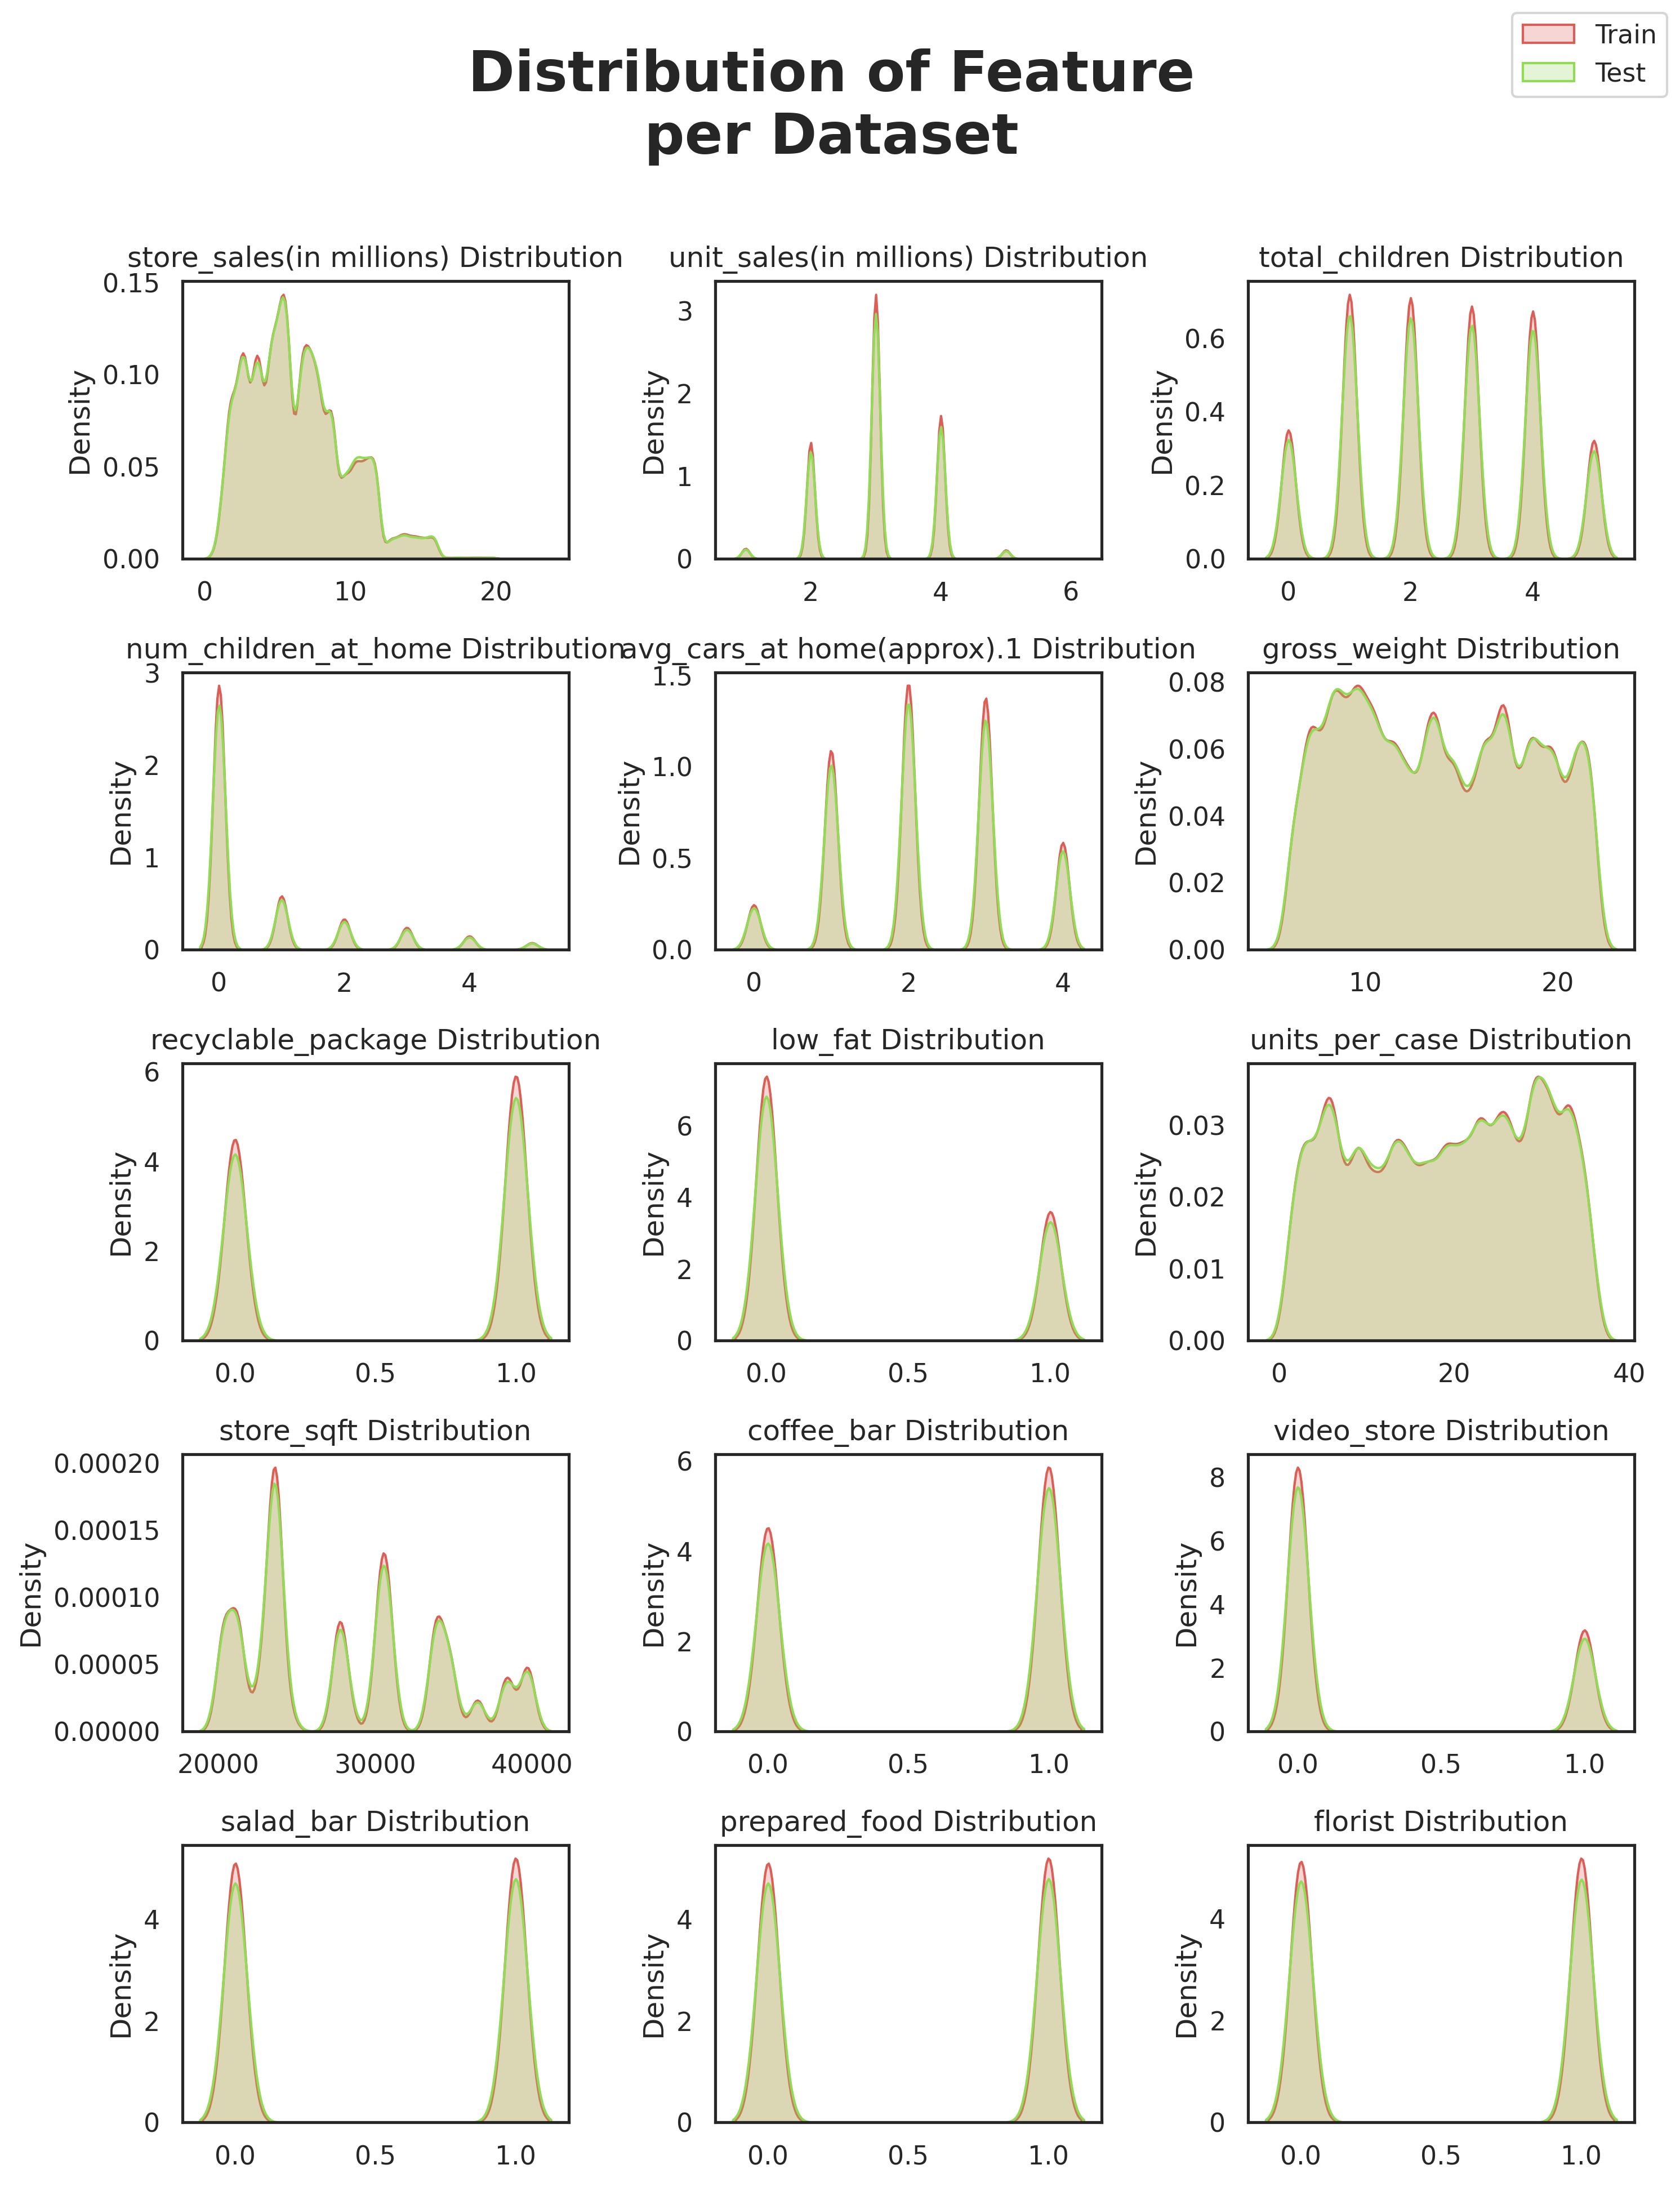

In [ ]:
fig, ax = plt.subplots(5, 3, figsize = (10, 13), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(test_df.columns):
    sns.kdeplot(train_df[column], ax=ax[i], color=pal[0], fill = True)
    sns.kdeplot(test_df[column], ax=ax[i], color=pal[2], fill = True)


    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

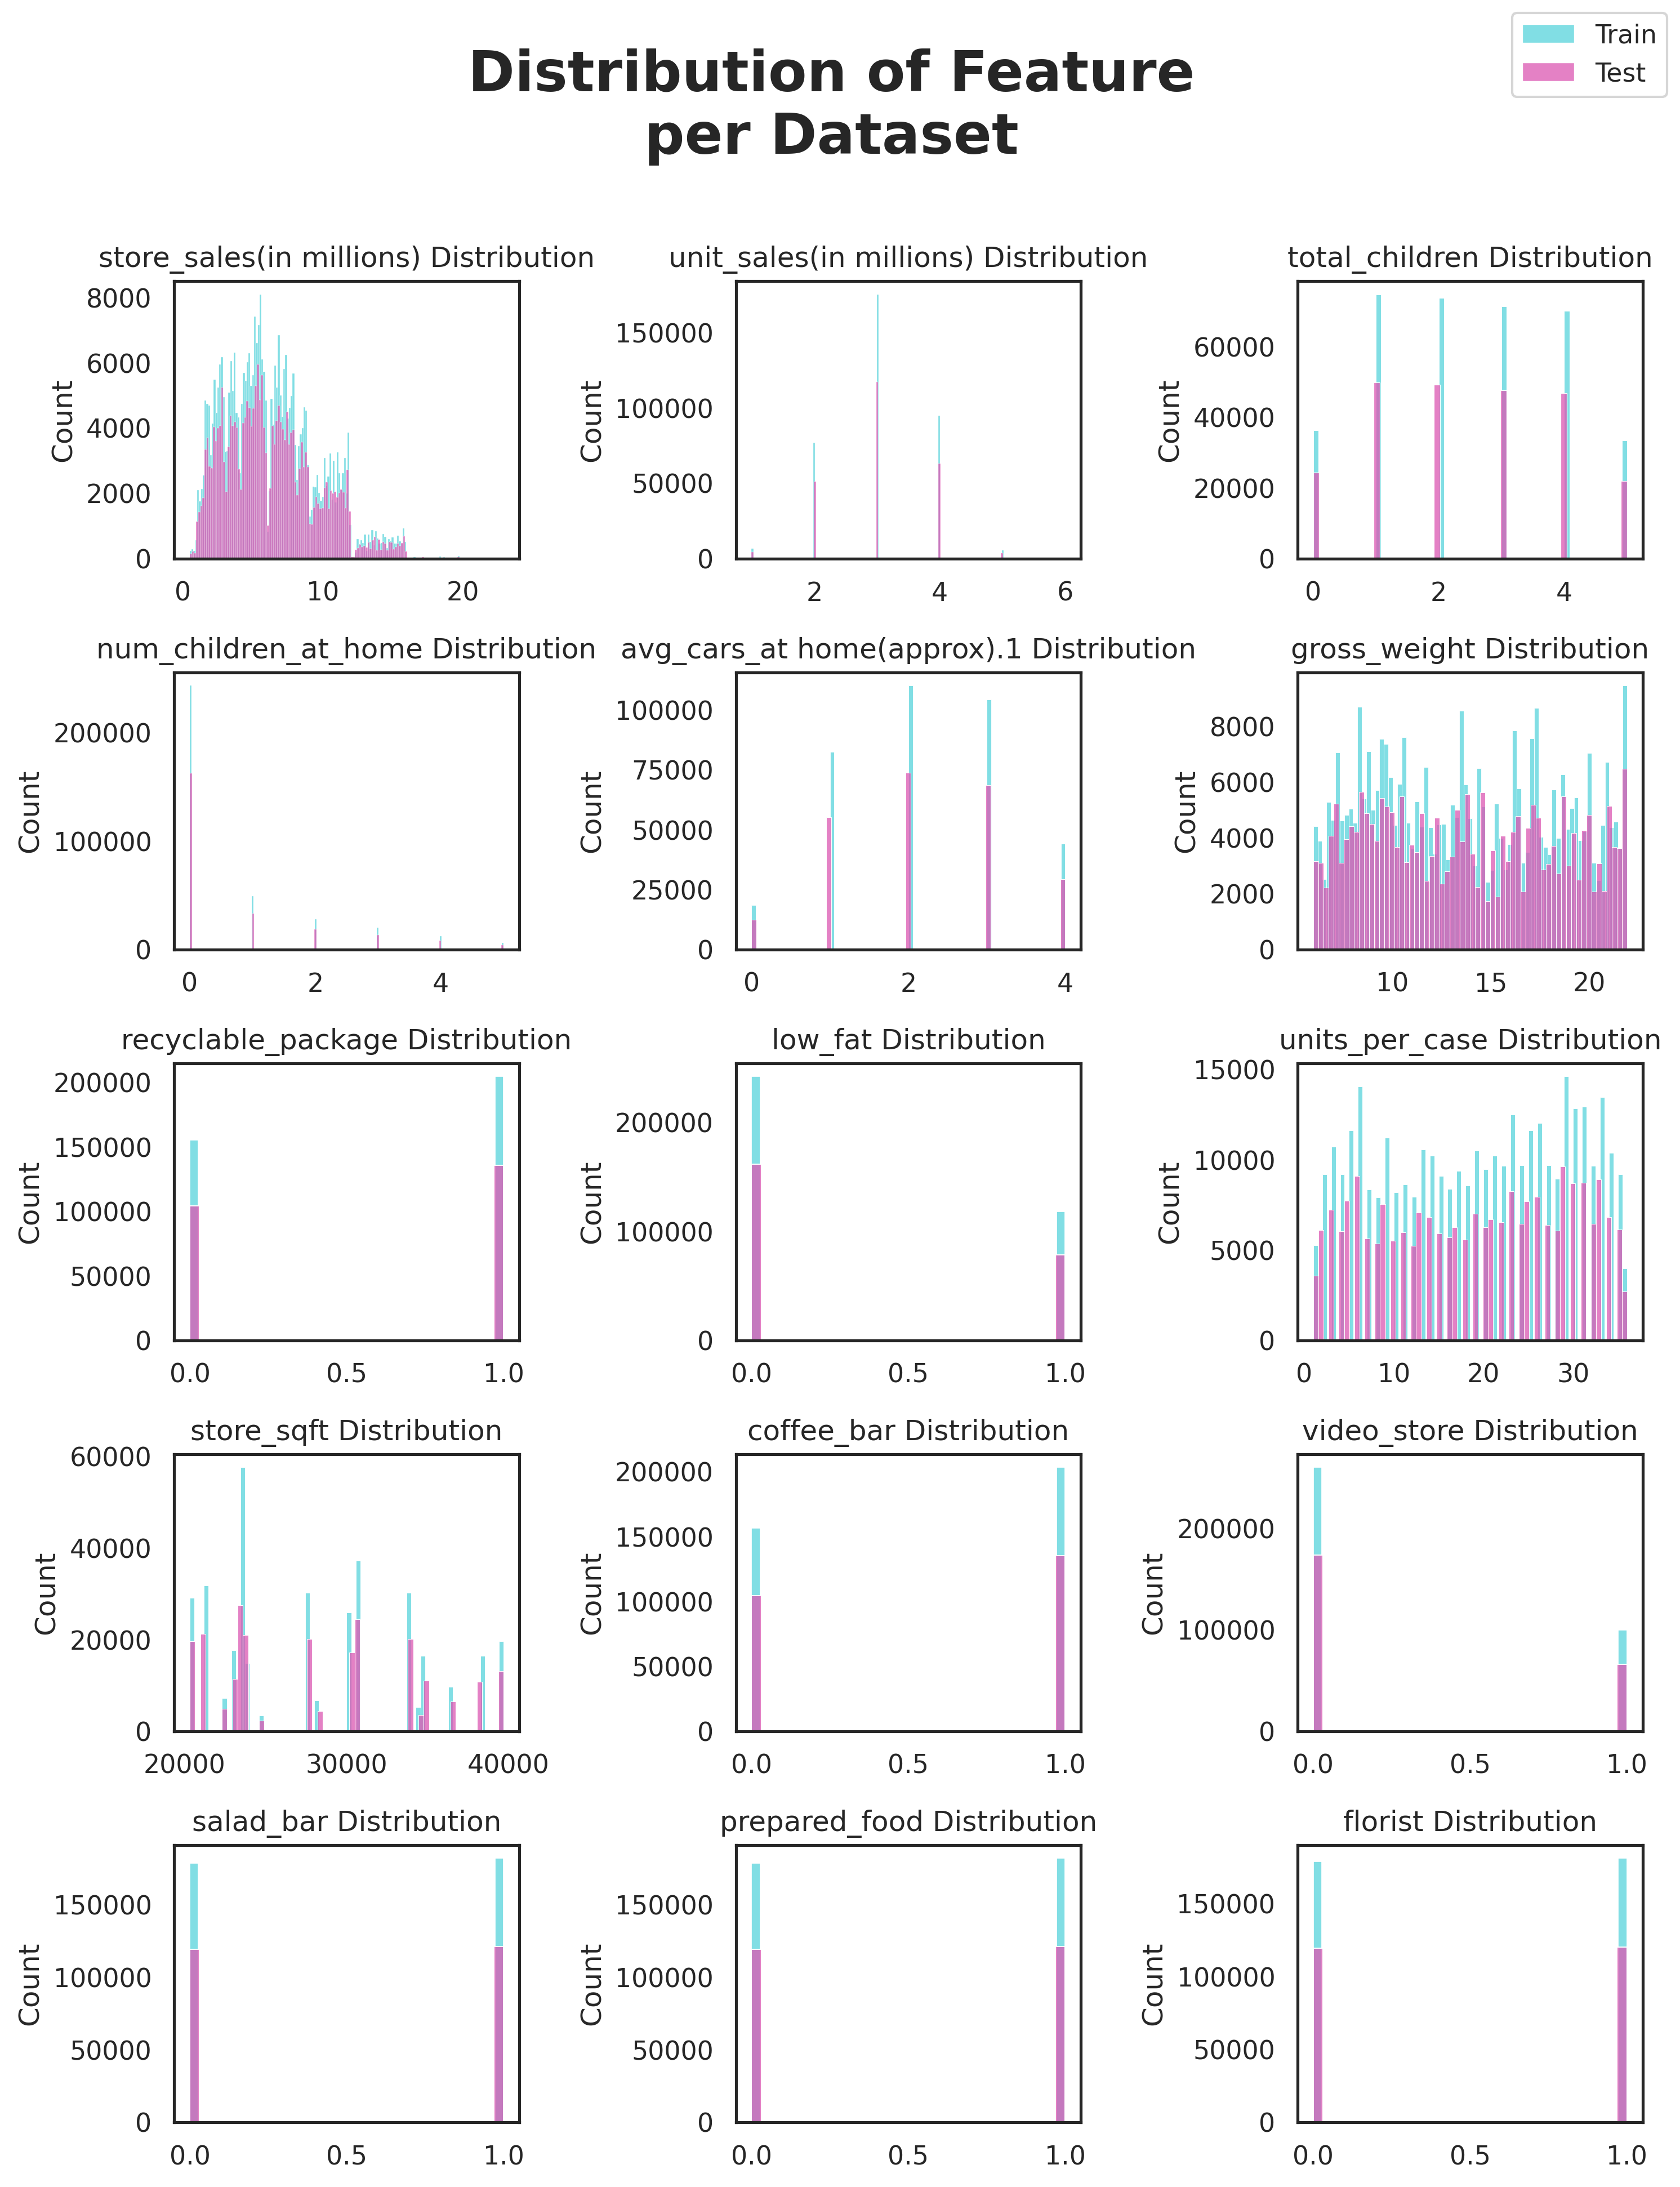

In [ ]:
fig, ax = plt.subplots(5, 3, figsize = (10, 13), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(test_df.columns):
    sns.histplot(train_df[column], ax=ax[i], color=pal[4], fill = True)
    sns.histplot(test_df[column], ax=ax[i], color=pal[7], fill = True)


    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

In [ ]:
def heatmap(dataset, label = None):
    corr = dataset.corr()
    plt.figure(figsize = (14, 10), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, annot = True, annot_kws = {'size' : 7}, cmap = pal)
    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

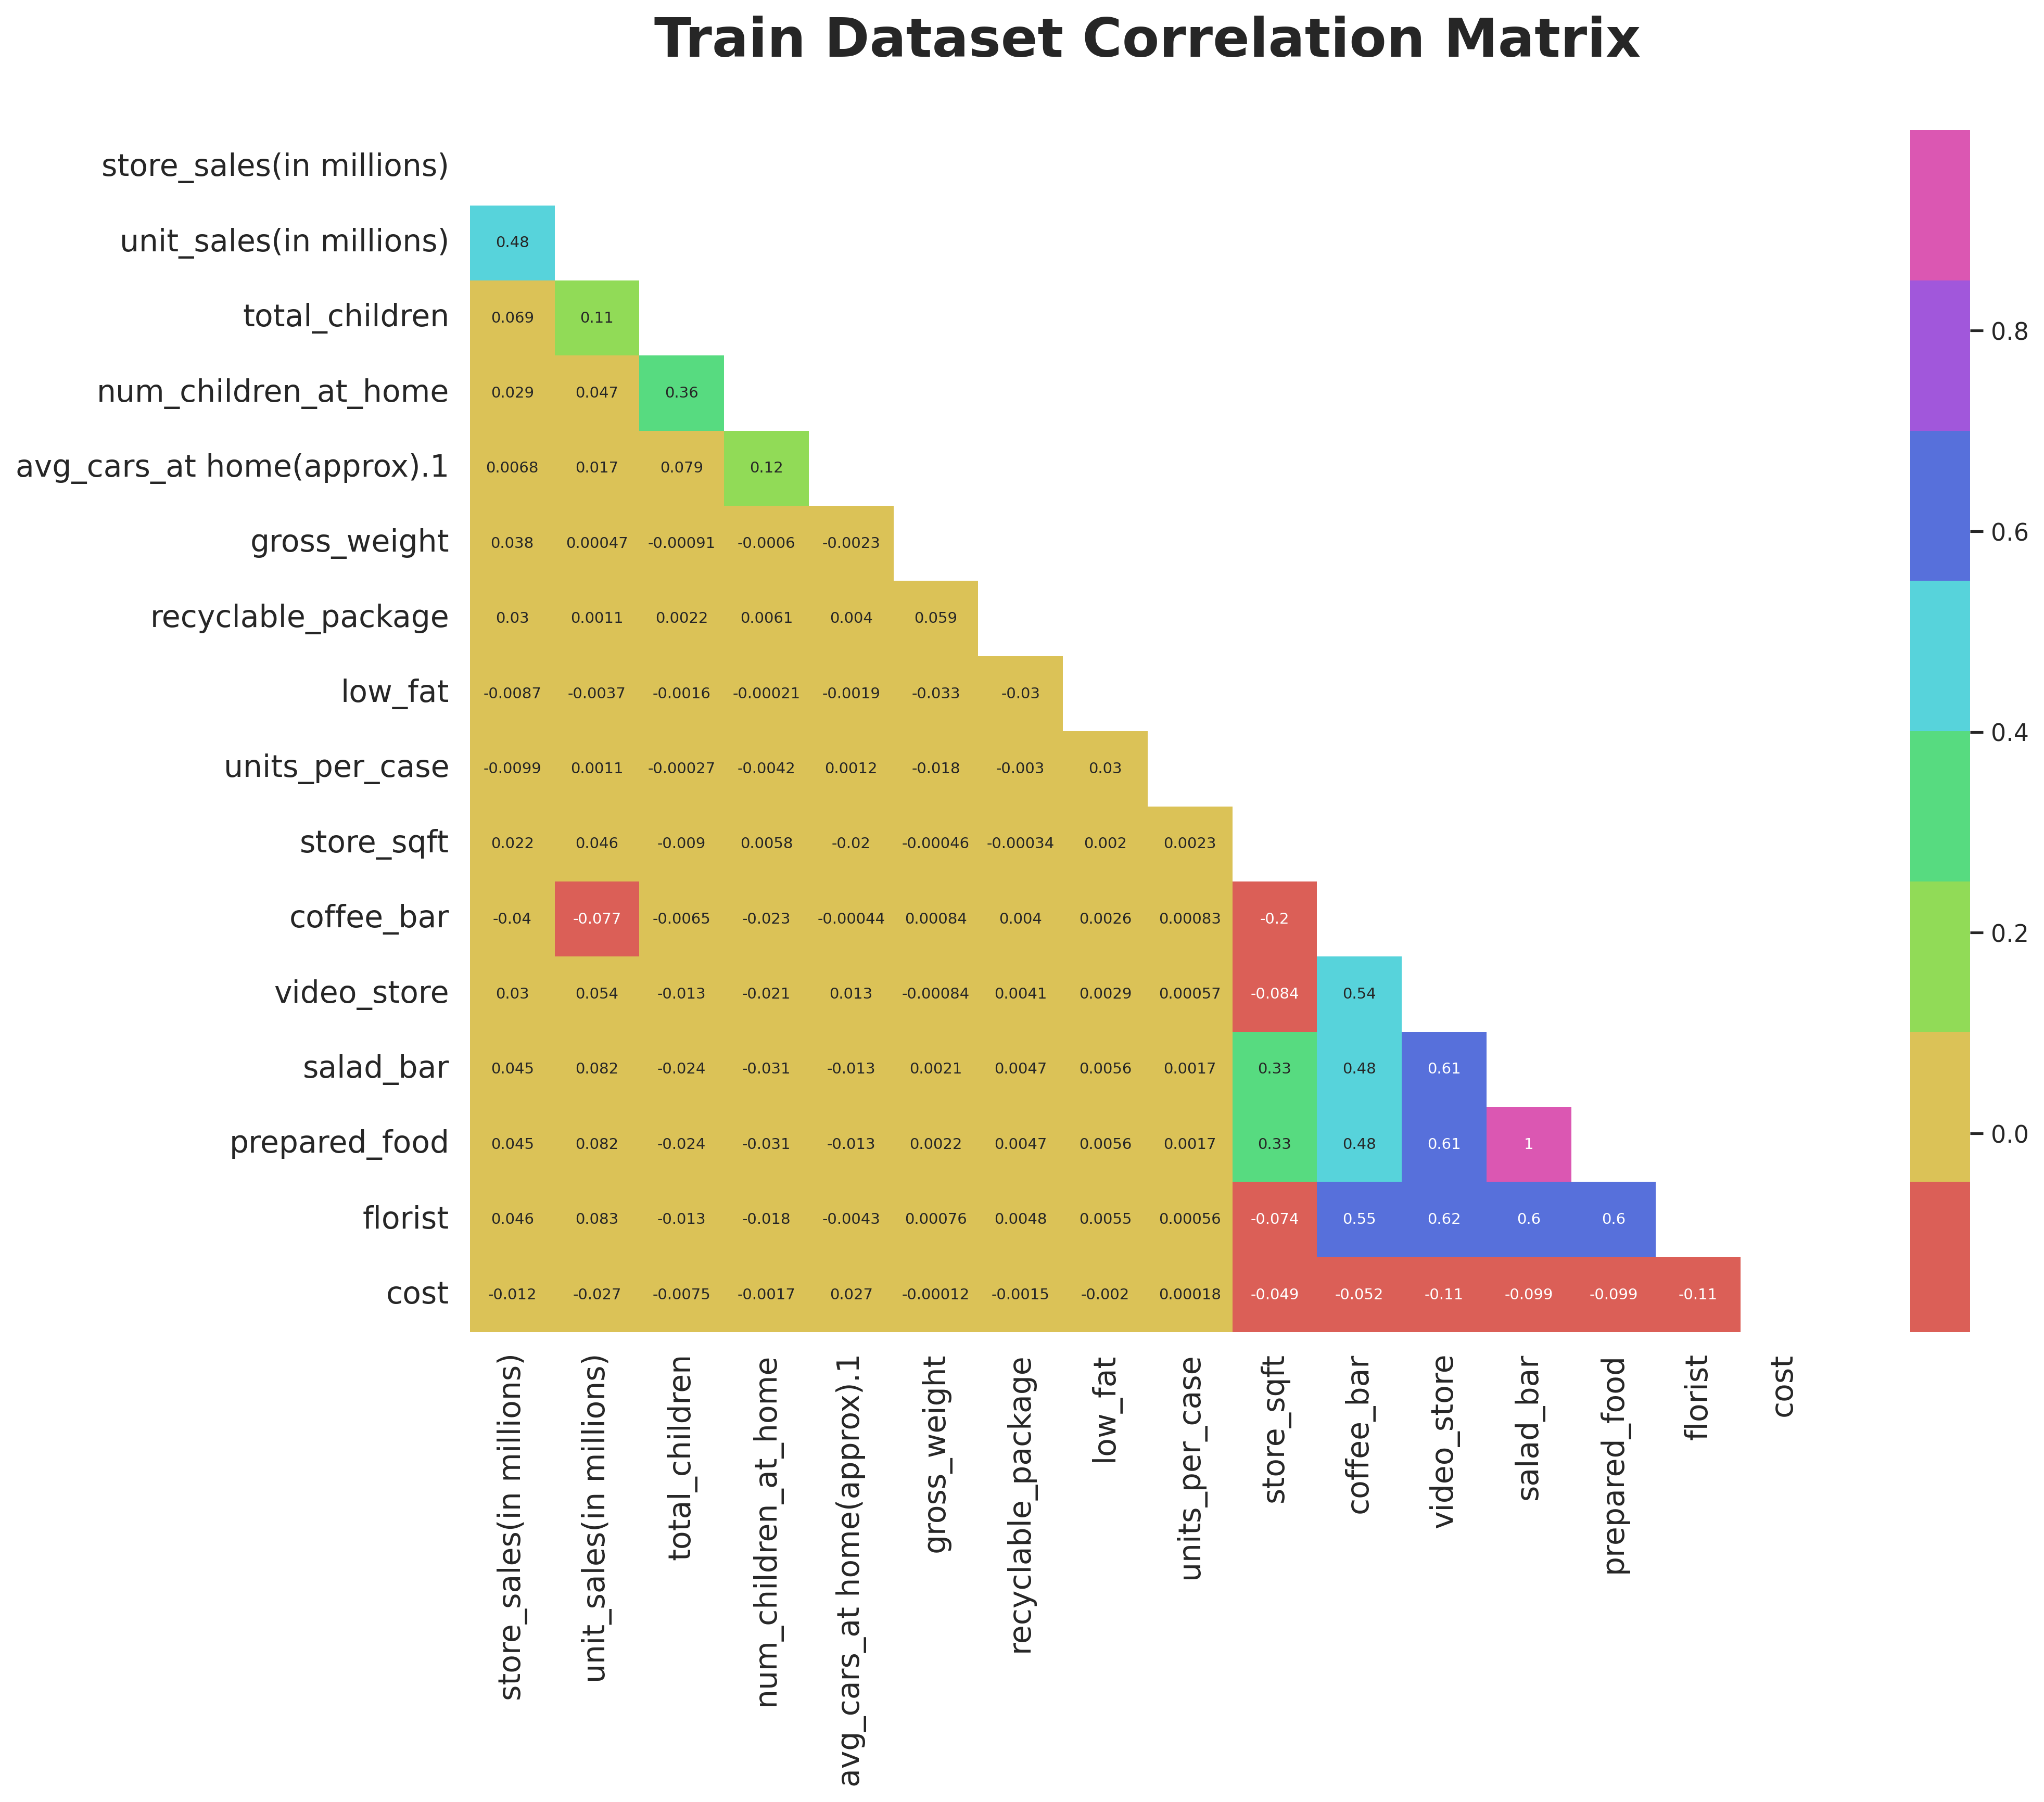

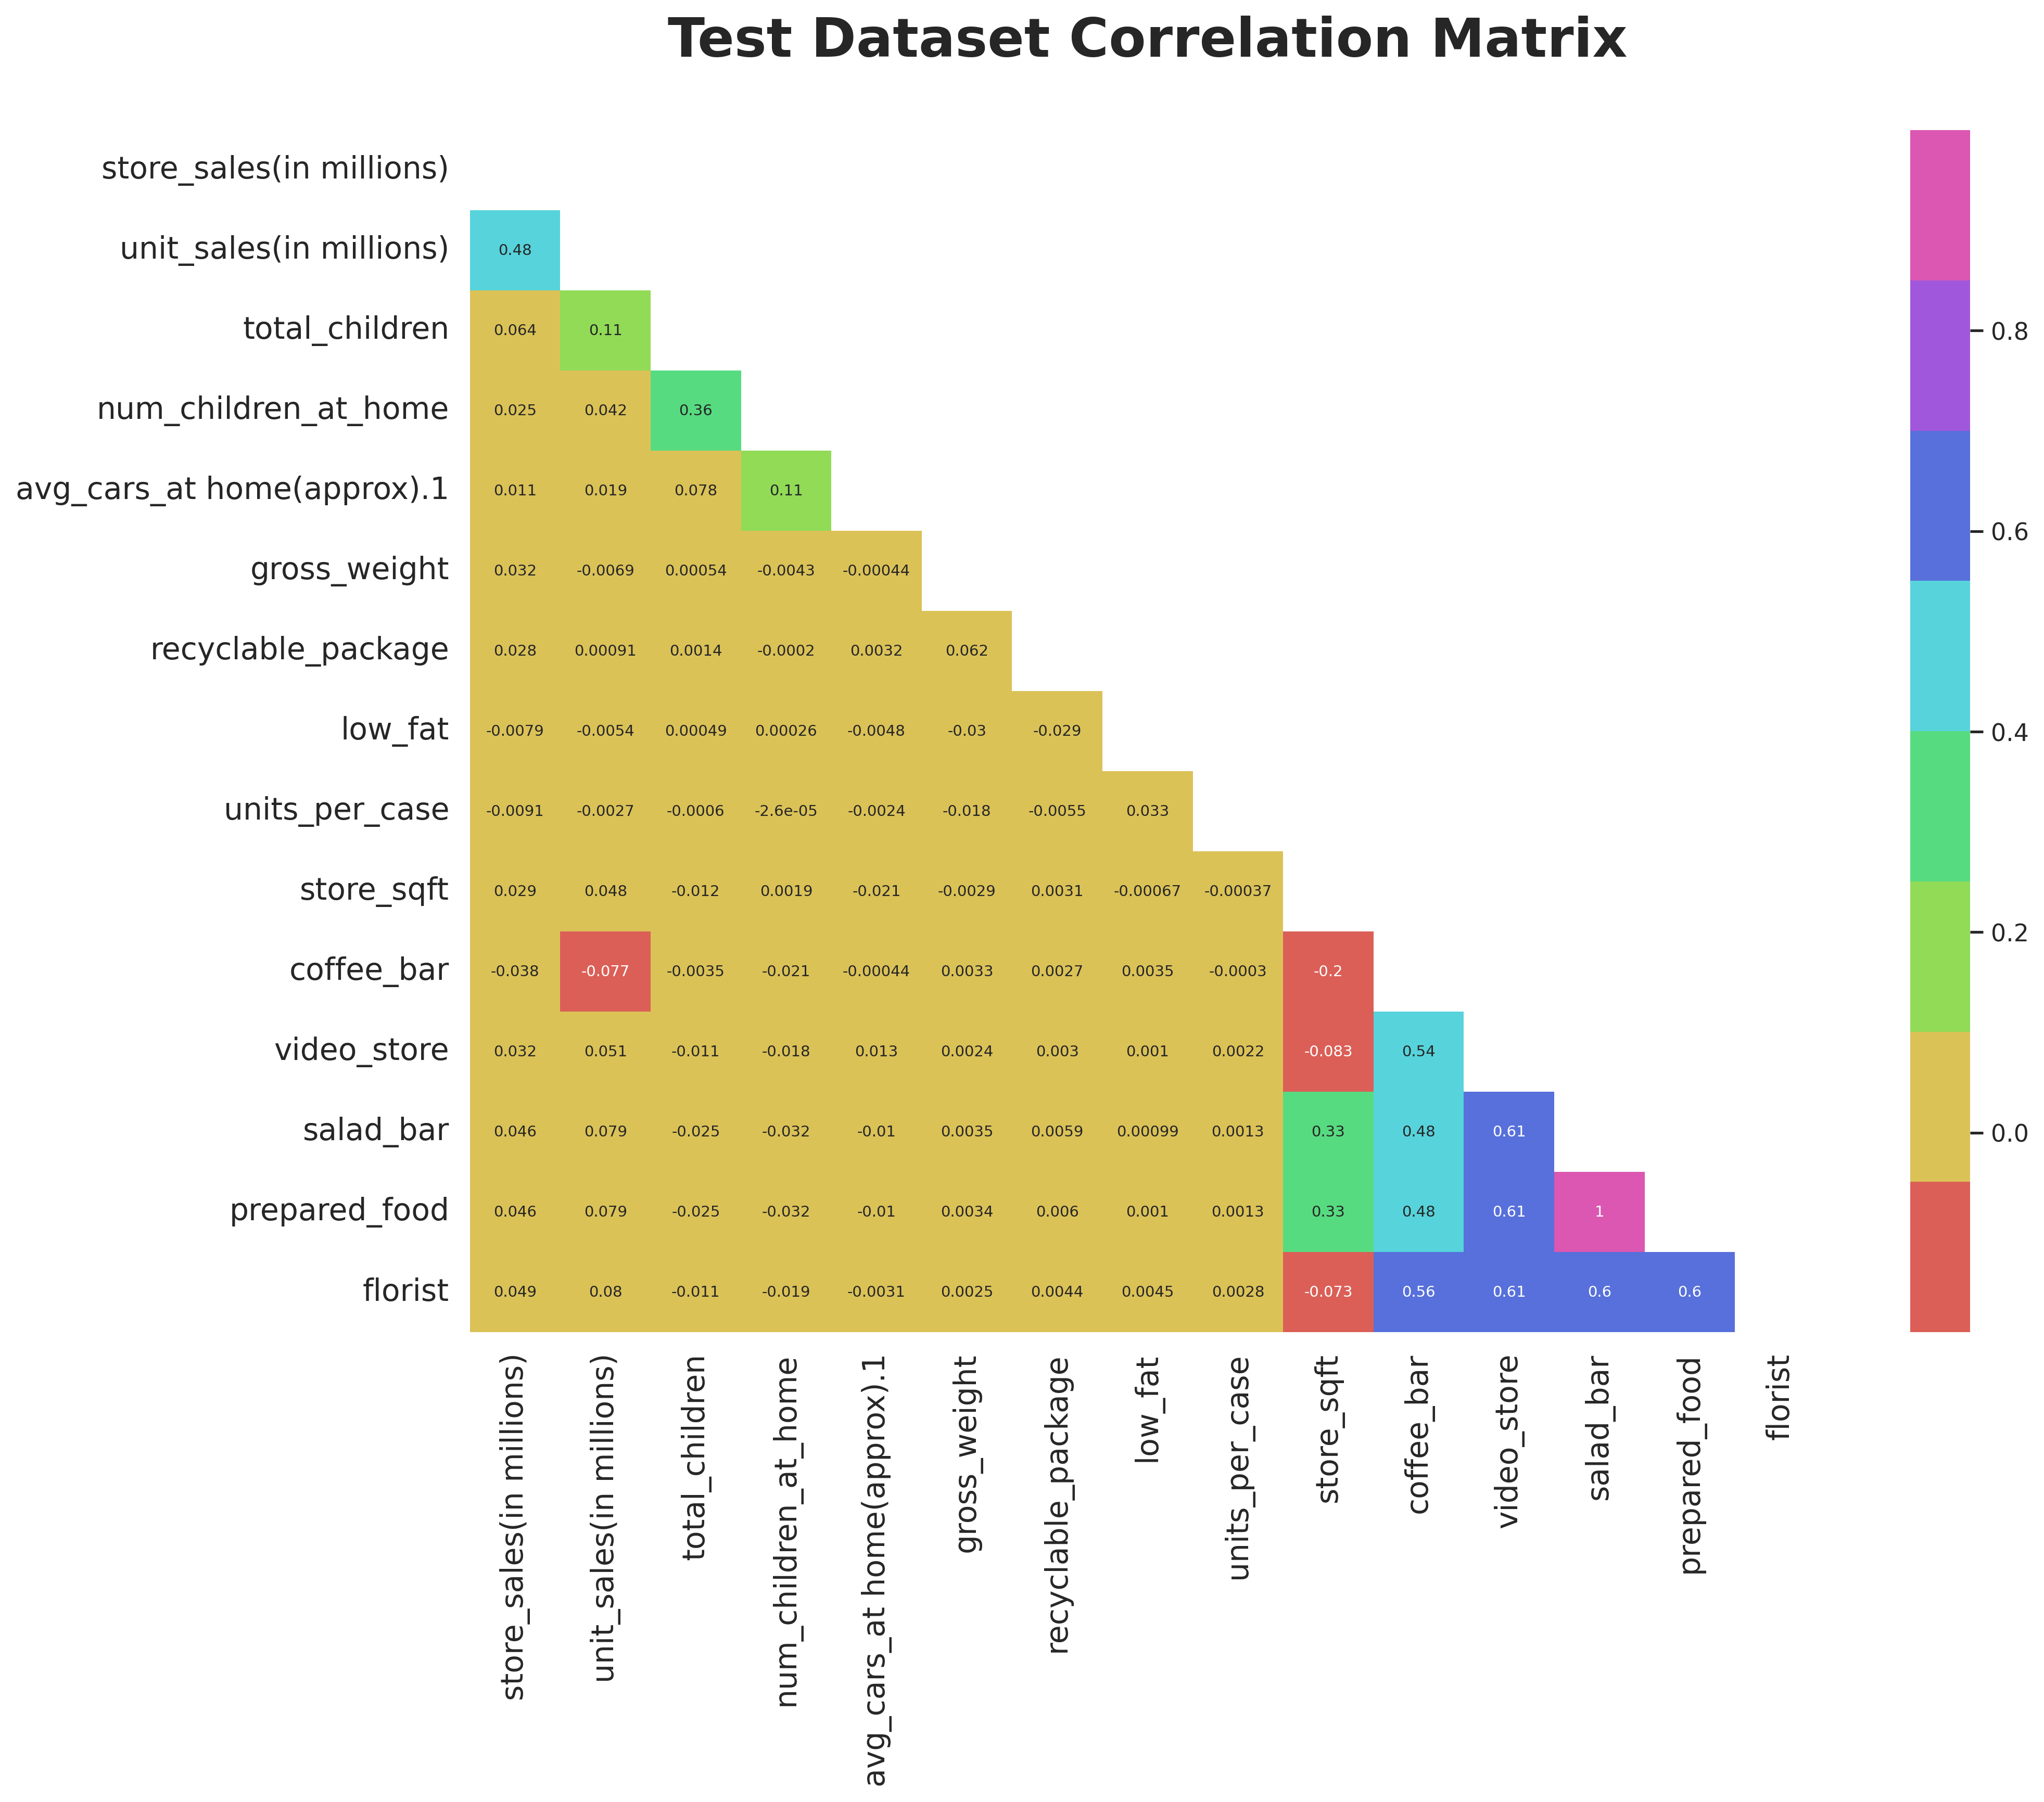

In [ ]:
heatmap(train_df, 'Train')
heatmap(test_df, 'Test')

# Data Preparation

In [120]:
train_df.head()

store_sales(in millions)  unit_sales(in millions)  total_children  \
0                      8.61                      3.0             2.0   
1                      5.00                      2.0             4.0   
2                     14.08                      4.0             0.0   
3                      4.02                      3.0             5.0   
4                      2.13                      3.0             5.0   

   num_children_at_home  avg_cars_at home(approx).1  gross_weight  \
0                   2.0                         2.0         10.30   
1                   0.0                         3.0          6.66   
2                   0.0                         3.0         21.30   
3                   0.0                         0.0         14.80   
4                   0.0                         3.0         17.00   

   recyclable_package  low_fat  units_per_case  store_sqft  coffee_bar  \
0                 1.0      0.0            32.0     36509.0         0.0   
1                 1.0      0.0             1.0     28206.0         1.0   
2                 1.0      0.0            26.0     21215.0         1.0   
3                 0.0      1.0            36.0     21215.0         1.0   
4                 1.0      1.0            20.0     27694.0         1.0   

   video_store  salad_bar  prepared_food  florist    cost  
0          0.0        0.0            0.0      0.0   62.09  
1          0.0        0.0            0.0      0.0  121.80  
2          0.0        0.0            0.0      0.0   83.51  
3          0.0        0.0            0.0      0.0   66.78  
4          1.0        1.0            1.0      1.0  111.51

In [121]:
test_df.head()

id  store_sales(in millions)  unit_sales(in millions)  total_children  \
0  360336                      7.24                      4.0             1.0   
1  360337                      6.90                      2.0             2.0   
2  360338                      8.34                      3.0             0.0   
3  360339                      5.48                      2.0             3.0   
4  360340                      4.80                      3.0             2.0   

   num_children_at_home  avg_cars_at home(approx).1  gross_weight  \
0                   0.0                         2.0         10.80   
1                   2.0                         3.0          8.51   
2                   0.0                         3.0          8.77   
3                   3.0                         2.0         21.90   
4                   0.0                         2.0         10.90   

   recyclable_package  low_fat  units_per_case  store_sqft  coffee_bar  \
0                 0.0      1.0             7.0     20319.0         0.0   
1                 1.0      0.0             4.0     33858.0         1.0   
2                 0.0      1.0            14.0     39696.0         0.0   
3                 1.0      0.0             9.0     23688.0         1.0   
4                 1.0      0.0            11.0     27694.0         1.0   

   video_store  salad_bar  prepared_food  florist  
0          0.0        0.0            0.0      0.0  
1          0.0        1.0            1.0      1.0  
2          0.0        1.0            1.0      0.0  
3          1.0        1.0            1.0      1.0  
4          1.0        1.0            1.0      1.0

In [122]:
train_df.shape

(360336, 16)

In [123]:
test_df.shape

(240224, 16)

In [124]:
# remove prepared food as prepared food and salad_bar have perfect correlation
train_df.drop(columns = ['prepared_food'], inplace = True)
test_df.drop(columns = ['prepared_food'], inplace = True)

In [125]:
# New features
store_features= ['coffee_bar', 'video_store', 'salad_bar', 'florist']

train_df['store_score'] = train_df[store_features].sum(axis = 1)
test_df['store_score'] = test_df[store_features].sum(axis = 1)

train_df['store_score_ratio'] =  train_df['store_score'] / train_df['store_sqft']
test_df['store_score_ratio'] = test_df['store_score'] / test_df['store_sqft']

In [126]:
train_df.shape

(360336, 17)

In [127]:
test_df.shape

(240224, 17)

In [130]:
selected_features = [
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'florist',
 'store_score',
 'store_score_ratio'
]

In [131]:
print('Unique values:')
for feature in selected_features:
    print(f'{feature:26} {np.unique(train_df[feature])}')

Unique values:
total_children             [0. 1. 2. 3. 4. 5.]
num_children_at_home       [0. 1. 2. 3. 4. 5.]
avg_cars_at home(approx).1 [0. 1. 2. 3. 4.]
store_sqft                 [20319. 21215. 22478. 23112. 23593. 23598. 23688. 23759. 24597. 27694.
 28206. 30268. 30584. 30797. 33858. 34452. 34791. 36509. 38382. 39696.]
coffee_bar                 [0. 1.]
video_store                [0. 1.]
salad_bar                  [0. 1.]
florist                    [0. 1.]
store_score                [0. 1. 2. 3. 4.]
store_score_ratio          [0.00000000e+00 2.51914551e-05 2.60538794e-05 2.73905065e-05
 2.87430657e-05 2.90258911e-05 2.95351173e-05 3.24706952e-05
 3.26968349e-05 3.30381922e-05 3.54534496e-05 3.61089045e-05
 4.06553645e-05 4.20893135e-05 4.22154677e-05 4.23764726e-05
 4.23854533e-05 4.32675666e-05 4.44879438e-05 4.71364601e-05
 4.92150204e-05 5.03829101e-05 5.21077588e-05 5.80517822e-05
 5.90702345e-05 6.49413904e-05 6.53936699e-05 6.60763843e-05
 7.09068992e-05 7.22178089e-05 7.557436

In [132]:
train_df['log_cost'] = np.log1p(train_df['cost'])

In [133]:
train_grouped = train_df.groupby(selected_features).log_cost.agg(['mean', 'std', 'count']).sort_values('count')
print('No. of groups = ', len(train_grouped))
train_grouped.tail(20)

No. of groups =  3060


mean  \
total_children num_children_at_home avg_cars_at home(approx).1 store_sqft coffee_bar video_store salad_bar florist store_score store_score_ratio             
2.0            0.0                  1.0                        33858.0    1.0        0.0         1.0       1.0     3.0         0.000089           4.431123   
1.0            0.0                  3.0                        33858.0    1.0        0.0         1.0       1.0     3.0         0.000089           4.635463   
3.0            0.0                  2.0                        21215.0    1.0        0.0         0.0       0.0     1.0         0.000047           4.624104   
                                    1.0                        33858.0    1.0        0.0         1.0       1.0     3.0         0.000089           4.378494   
0.0            0.0                  1.0                        27694.0    1.0        1.0         1.0       1.0     4.0         0.000144           4.458753   
3.0            0.0                  1.0                        20319.0    0.0        0.0         0.0       0.0     0.0         0.000000           4.617708   
1.0            0.0                  2.0                        23598.0    0.0        0.0         0.0       1.0     1.0         0.000042           4.471473   
3.0            0.0                  2.0                        23598.0    0.0        0.0         0.0       1.0     1.0         0.000042           4.598826   
1.0            0.0                  2.0                        30268.0    0.0        0.0         0.0       0.0     0.0         0.000000           4.514182   
4.0            0.0                  1.0                        30268.0    0.0        0.0         0.0       0.0     0.0         0.000000           4.616415   
                                    2.0                        27694.0    1.0        1.0         1.0       1.0     4.0         0.000144           4.467303   
3.0            0.0                  2.0                        33858.0    1.0        0.0         1.0       1.0     3.0         0.000089           4.538850   
1.0            0.0                  1.0                        30268.0    0.0        0.0         0.0       0.0     0.0         0.000000           4.511898   
4.0            0.0                  3.0                        27694.0    1.0        1.0         1.0       1.0     4.0         0.000144           4.416005   
1.0            0.0                  2.0                        21215.0    1.0        0.0         0.0       0.0     1.0         0.000047           4.590567   
                                                               20319.0    0.0        0.0         0.0       0.0     0.0         0.000000           4.515137   
                                    1.0                        21215.0    1.0        0.0         0.0       0.0     1.0         0.000047           4.554539   
                                    2.0                        27694.0    1.0        1.0         1.0       1.0     4.0         0.000144           4.322897   
                                                               30797.0    1.0        1.0         1.0       1.0     4.0         0.000130           4.520480   
                                    1.0                        33858.0    1.0        0.0         1.0       1.0     3.0         0.000089           4.521471   

                                                                                                                                                       std  \
total_children num_children_at_home avg_cars_at home(approx).1 store_sqft coffee_bar video_store salad_bar florist store_score store_score_ratio             
2.0            0.0                  1.0                        33858.0    1.0        0.0         1.0       1.0     3.0         0.000089           0.334193   
1.0            0.0                  3.0                        33858.0    1.0        0.0         1.0       1.0     3.0         0.000089           0.345549   
3.0            0.0                  2.0  

In [134]:
# Scale the store_sqft column using MinMaxScaler
scaler = MinMaxScaler()
train_df['store_sqft'] = scaler.fit_transform(train_df[['store_sqft']])
test_df['store_sqft'] = scaler.fit_transform(test_df[['store_sqft']])

## Ignore

In [ ]:
# def feature_eng(df):
#     # Ratio of children at home to total_children
#     df['children_per_adult']= df['num_children_at_home'] / df['total_children']
#     df['children_per_adult'].replace([np.inf, -np.inf], 10, inplace = True)
#     df['children_per_adult'].fillna(0, inplace = True)

#     # Weight per unit
#     df['weight_per_unit'] = df['gross_weight'] / df['unit_sales(in millions)']
#     df['weight_per_unit'].replace([np.inf, -np.inf, np.nan], 0, inplace = True)

#     # Num of units sold per area
#     df['Units_per_area'] = df['unit_sales(in millions)'] / df['store_sqft']
#     df['Units_per_area'].replace([np.inf, -np.inf, np.nan], 0, inplace = True)

#     # sales per unit
#     df['sales_per_unit'] = df['store_sales(in millions)'] / df['unit_sales(in millions)']
#     df['sales_per_unit'].replace([np.inf, -np.inf, np.nan], 0, inplace = True)

#     # sales_per_unit_weight
#     df['sales_per_unit_weight'] = df['store_sales(in millions)'] / df['gross_weight']
#     df['sales_per_unit_weight'].replace([np.inf, -np.inf, np.nan], 0, inplace = True)

#     # Sales per area of the shop
#     df['sales_per_area'] = df['store_sales(in millions)'] / df['store_sqft']
#     df['sales_per_area'].replace([np.inf, -np.inf, np.nan], 0, inplace = True)

#     # Presence of any amenities
#     df[['coffee_bar', 'video_store', 'low_fat', 'salad_bar', 'florist']] = df[['coffee_bar', 'video_store', 'low_fat', 'salad_bar', 'florist']].astype(int)

#     df['any_amenities'] = df[['coffee_bar', 'video_store', 'salad_bar', 'florist']].any(axis=1)

#     # Num of independent_children
#     df['independent_children'] = df['total_children'] - df['num_children_at_home']
#     df['independent_children'].replace([np.inf, -np.inf, np.nan], 0, inplace = True)

#     # Create a new feature for child-to-car ratio
#     # the transportation needs of households with children
#     df['child_to_car_ratio'] = df['total_children'] / df['avg_cars_at home(approx).1']
#     df['child_to_car_ratio'].replace([np.inf, -np.inf], 10, inplace = True)
#     df['child_to_car_ratio'].fillna(0, inplace = True)

#     # Create a new feature for healthy food options
#     df['healthy_food_options'] = df['low_fat'] & df['salad_bar']

#     # Create a new feature for customer age group
#     df['customer_age_group'] = df['total_children'] / df['num_children_at_home']
#     df['customer_age_group'].replace([np.inf, -np.inf], 10, inplace = True)
#     df['customer_age_group'].fillna(0, inplace = True)

#     return df

In [ ]:
# train_df = feature_eng(train_df)
# test_df = feature_eng(test_df)

In [ ]:
# # check for NaN values
# print(train_df.isna().sum())
# # check for infinity values
# print(np.isinf(train_df).sum())

In [ ]:
# # Define a function to find X and y arrays for a given dataframe either test or train
# def getXy(df, X_labels = None, y_label = None, cat_labels = None):
#     # cases where X_label is not given and it is all the features except target
#     if X_labels is None:
#         X = df[[c for c in df.columns if c != y_label]].values
#     else:
#         # Change the X array to one column when there is only one X_label
#         if len(X_labels) == 1:
#             X = df[X_labels].values.reshape(-1,1)
#         else:
#             # Find X based on the given X_labels when there are multiple X_labels
#             X = df[X_labels].values

#     if y_label is None:
#         # Create a zero array in the case of test set which we dont want the y_test
#         y = np.zeros(df.shape[0]).reshape(-1,1)
#     else:
#         y = df[y_label].values

#     # Use One Hot encoding for categorical features
#     if cat_labels is None:
#         # create a new dataframe with X and Y
#         label = np.hstack((X_labels, y_label))
#         data = pd.DataFrame(np.hstack((X, y.reshape(-1,1))), columns = label)
#     else:
#         data = pd.get_dummies(df, columns = cat_labels)
#     return data, X, y

In [ ]:
# engineer_labels = ['children_per_adult','independent_children','customer_age_group','any_amenities','child_to_car_ratio']
# selected_features.extend(engineer_labels)
# print(selected_features)

In [ ]:
# names = list(train_df.columns)
# print(names)
# item_to_remove=['recyclable_package','store_sales(in millions)','units_per_case',
#                 'low_fat','gross_weight','unit_sales(in millions)','cost']
# for i in item_to_remove:
#     names.remove(i)
# # names.extend(engineer_labels)
# features = [c for c in names if c != 'cost']
# print(names)

In [ ]:
# train = train.loc[:,~train.columns.duplicated()].copy()
# train.shape

In [ ]:
# test = test.loc[:,~test.columns.duplicated()].copy()
# test.shape

In [ ]:
# train,X,y = getXy(train_df, X_labels = names, y_label = 'cost')
# print(X.shape)
# print(y.shape)

In [ ]:
# test,X_,y_ = getXy(test_df, X_labels = names)
# print(X_.shape)
# print(y_.shape)

In [ ]:
# # Splitting dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = RANDOM_STATE)
# print(f'Training set has {X_train.shape} examples and test set has {X_test.shape}.')

# Models Trial 3.0

## Model Training

In [54]:
results = {}

def fit_model_grouped(model, train, features):
    '''
    Group duplicates in train_df and fit the model with the correct sample_weight
    '''

    train_grouped = train.groupby(features).log_cost.agg(['mean', 'count']).reset_index()
    X_train = train_grouped[features]
    y_train = train_grouped['mean']
    sample_weight_train = train_grouped['count']

    if type(model) == Pipeline:
        sample_weight_name = model.steps[-1][0] + '__sample_weight'
    else:
        sample_weight_name = 'sample_weight'

    model.fit(X_train, y_train, **{sample_weight_name: sample_weight_train})


def cross_validation(model, features, label):
    scores = []

    val_preds = np.zeros_like(train_df['log_cost'], dtype = float)
    k = KFold(shuffle = True, random_state = RANDOM_STATE)
    for fold, (train_idx, val_idx) in enumerate(k.split(train_df)):
        X_val = train_df.iloc[val_idx][features]
        y_val = train_df.iloc[val_idx]['log_cost']

        fit_model_grouped(model, train_df.iloc[train_idx], features)

        y_val_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_pred, squared = False)
        print(f'Fold {fold}: rmse = {rmse}')
        val_preds[val_idx] = y_val_pred
        scores.append(rmse)

    avg_rmse = sum(scores) / len(scores)
    print(f"Average RMSE: {avg_rmse} {label}")
    results[label]  = (model, features, avg_rmse, val_preds)

In [55]:
%%time
cross_validation(RandomForestRegressor(bootstrap = False, max_features = 6, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                       random_state = RANDOM_STATE), selected_features, label = 'RF')

Fold 0: rmse = 0.2932919185435533
Fold 1: rmse = 0.29182468222917596
Fold 2: rmse = 0.2929420662979327
Fold 3: rmse = 0.2931134179283942
Fold 4: rmse = 0.29402137267837253
Average RMSE: 0.29303869153548573 RF
CPU times: user 34.4 s, sys: 139 ms, total: 34.6 s
Wall time: 34.9 s


In [57]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = list(set(selected_features) - {'store_score', 'store_score_ratio'}), handle_unknown = 'error'),
                               RandomForestRegressor(bootstrap = False, max_features = 6, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                     random_state = 42)), selected_features, label = 'Target-RF')

Fold 0: rmse = 0.2933617546741887
Fold 1: rmse = 0.2917807615925902
Fold 2: rmse = 0.2929537853084215
Fold 3: rmse = 0.2931508544179567
Fold 4: rmse = 0.2940175316139696
Average RMSE: 0.29305293752142536 Target-RF
CPU times: user 36.1 s, sys: 186 ms, total: 36.3 s
Wall time: 36.6 s


In [58]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = ['store_sqft'], handle_unknown = 'error'),
                               RandomForestRegressor(bootstrap = False, max_features = 6, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                     random_state = 42)), selected_features, label = 'Target-RF store-sqft')

Fold 0: rmse = 0.2932973526839238
Fold 1: rmse = 0.2917791375053565
Fold 2: rmse = 0.2929097042328611
Fold 3: rmse = 0.2931083939732014
Fold 4: rmse = 0.2940393805396117
Average RMSE: 0.2930267937869909 Target-RF store-sqft
CPU times: user 34.8 s, sys: 111 ms, total: 34.9 s
Wall time: 35.6 s


In [59]:
%%time
cross_validation(ExtraTreesRegressor(bootstrap = False, max_features = 7, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                       random_state = RANDOM_STATE), selected_features, label = 'ET')

Fold 0: rmse = 0.2933762938898504
Fold 1: rmse = 0.2918775419621415
Fold 2: rmse = 0.29302395057677466
Fold 3: rmse = 0.29317784511737055
Fold 4: rmse = 0.29408015124241493
Average RMSE: 0.2931071565577104 ET
CPU times: user 34.6 s, sys: 147 ms, total: 34.7 s
Wall time: 38.8 s


In [60]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = list(set(selected_features) - {'store_score', 'store_score_ratio'}), handle_unknown = 'error'),
                               ExtraTreesRegressor(bootstrap = False, max_features = 7, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                     random_state = 42)), selected_features, label = 'Target-ET')

Fold 0: rmse = 0.2933913093324594
Fold 1: rmse = 0.29189109805849495
Fold 2: rmse = 0.2930956291794299
Fold 3: rmse = 0.2932406356136952
Fold 4: rmse = 0.29407415988322516
Average RMSE: 0.2931385664134609 Target-ET
CPU times: user 40.7 s, sys: 165 ms, total: 40.8 s
Wall time: 48.6 s


In [61]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = ['store_sqft'], handle_unknown = 'error'),
                               ExtraTreesRegressor(bootstrap = False, max_features = 7, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                   random_state = 42)), selected_features, label = 'Target-ET store_sqft')

Fold 0: rmse = 0.2933352047850524
Fold 1: rmse = 0.2917788894325334
Fold 2: rmse = 0.2929999626247075
Fold 3: rmse = 0.29314937022372345
Fold 4: rmse = 0.29408503054496193
Average RMSE: 0.2930696915221957 Target-ET store_sqft
CPU times: user 35.5 s, sys: 289 ms, total: 35.7 s
Wall time: 37.7 s


In [62]:
%%time
params_catb = {'n_estimators': 4000,
             'max_depth': 12,
             'learning_rate': 0.1,
             'verbose': False,
             'boost_from_average': True,
            }

cross_validation(CatBoostRegressor(**params_catb), selected_features, 'CatBoost')

Fold 0: rmse = 0.2932700663120795
Fold 1: rmse = 0.29179884615073276
Fold 2: rmse = 0.2928956567005565
Fold 3: rmse = 0.29305433919231777
Fold 4: rmse = 0.29401092770571036
Average RMSE: 0.2930059672122794 CatBoost
CPU times: user 3min 43s, sys: 16.5 s, total: 3min 59s
Wall time: 2min 43s


In [63]:
params_lgbm = {
    'learning_rate': 0.1,
    'n_estimators': 450,
    'num_leaves': 100,
    'min_child_samples': 1,
    'min_child_weight': 1e1,
    'random_state': 1
}
cross_validation(LGBMRegressor(**params_lgbm), selected_features, 'LightGBM')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 2913, number of used features: 10
[LightGBM] [Info] Start training from score 4.563652
Fold 0: rmse = 0.29325388752971066
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 2926, number of used features: 10
[LightGBM] [Info] Start training from score 4.5630

In [64]:
%%time
params_dart = {'boosting_type': 'dart',
               'learning_rate': 0.3,
               'n_estimators': 400,
               'num_leaves': 200,
               'min_child_samples': 1,
               'min_child_weight': 10,
              }
cross_validation(LGBMRegressor(**params_dart), selected_features, 'Dart')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 2913, number of used features: 10
[LightGBM] [Info] Start training from score 4.563652
Fold 0: rmse = 0.29325162374601327
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 2926, number of used features: 10
[LightGBM] [Info] Start training from score 4.563017
Fold 1: rmse = 0.29177609496965323
[LightGBM] [Warning] Found

## Results + Linear Combination

In [65]:
results

{'RF': (RandomForestRegressor(bootstrap=False, max_features=6,
                        min_weight_fraction_leaf=1.2488344212068736e-05,
                        n_estimators=400, random_state=42),
  ['total_children',
   'num_children_at_home',
   'avg_cars_at home(approx).1',
   'store_sqft',
   'coffee_bar',
   'video_store',
   'salad_bar',
   'florist',
   'store_score',
   'store_score_ratio'],
  0.29303869153548573,
  array([4.64924251, 4.68667951, 4.63029164, ..., 4.55017007, 4.65107872,
         4.49109406])),
 'Target-RF': (Pipeline(steps=[('targetencoder',
                   TargetEncoder(cols=['num_children_at_home', 'florist',
                                       'coffee_bar', 'salad_bar',
                                       'avg_cars_at home(approx).1', 'store_sqft',
                                       'total_children', 'video_store'],
                                 handle_unknown='error', verbose=30)),
                  ('randomforestregressor',
                 

In [66]:
k = KFold(shuffle = True, random_state = RANDOM_STATE)
y_vals = np.zeros_like(train_df['log_cost'], dtype = float)
for fold, (train_idx, val_idx) in enumerate(k.split(train_df)):
        y_val = train_df.iloc[val_idx]['log_cost']
        y_vals[val_idx] = y_val

In [68]:
five = 0.3 * results['LightGBM'][-1] + 0.2 * results['Dart'][-1] + 0.2 * results['CatBoost'][-1] + 0.15 * results['Target-RF store-sqft'][-1] + 0.15 * results['RF'][-1]
print('RMSLE = ', mean_squared_error(y_vals, five, squared = False))

RMSLE =  0.29295871602929746


In [70]:
submission_pred = 0.3 * results['LightGBM'][0].predict(test_df[selected_features]) + 0.2 * results['Dart'][0].predict(test_df[selected_features]) + 0.2 * results['CatBoost'][0].predict(test_df[selected_features]) + 0.15 * results['Target-RF store-sqft'][0].predict(test_df[selected_features]) + 0.15 * results['RF'][0].predict(test_df[selected_features])
export = np.hstack((np.reshape(test_df['id'].values, (-1,1)), np.reshape(np.expm1(submission_pred), (-1,1))))
submission = pd.DataFrame(export, columns = ['id', 'cost'])
submission.to_csv(r'drive/MyDrive/SC4000/submission_new day_1.csv', index = False, header = ['id', 'cost'])
submission.shape

(240224, 2)

# Models Trial 2.0

## Model training

In [ ]:
results = []

def fit_model_grouped(model, train, features):
    '''
    Group duplicates in train_df and fit the model with the correct sample_weight
    '''

    train_grouped = train.groupby(features).log_cost.agg(['mean', 'count']).reset_index()
    X_train = train_grouped[features]
    y_train = train_grouped['mean']
    sample_weight_train = train_grouped['count']

    if type(model) == Pipeline:
        sample_weight_name = model.steps[-1][0] + '__sample_weight'
    else:
        sample_weight_name = 'sample_weight'

    model.fit(X_train, y_train, **{sample_weight_name: sample_weight_train})


def cross_validation(model, features, label):
    scores = []

    val_preds = np.zeros_like(train_df['log_cost'], dtype = float)
    k = KFold(shuffle = True, random_state = RANDOM_STATE)
    for fold, (train_idx, val_idx) in enumerate(k.split(train_df)):
        X_val = train_df.iloc[val_idx][features]
        y_val = train_df.iloc[val_idx]['log_cost']

        fit_model_grouped(model, train_df.iloc[train_idx], features)

        y_val_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_pred, squared = False)
        print(f'Fold {fold}: rmse = {rmse}')
        val_preds[val_idx] = y_val_pred
        scores.append(rmse)

    avg_rmse = sum(scores) / len(scores)
    print(f"Average RMSE: {avg_rmse} {label}")
    results.append((label, model, features, avg_rmse, val_preds))

### RF

In [ ]:
%%time
cross_validation(RandomForestRegressor(bootstrap = False, max_features = 6, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                       random_state = RANDOM_STATE), selected_features, label = 'RF')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.2932984428091074


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.29178612428160294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.29292497440008836


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.2931080726285358
Fold 4: rmse = 0.2940568170759061
Average RMSE: 0.2930348862390481 RF
CPU times: user 38.8 s, sys: 163 ms, total: 39 s
Wall time: 42.5 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = selected_features, handle_unknown = 'error'),
                               RandomForestRegressor(bootstrap = False, max_features = 6, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                     random_state = 42)), selected_features, label = 'Target-RF')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.2933937164477427


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.29176660671544724


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.2929663241656536


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.2931841267224412
Fold 4: rmse = 0.29407762069513554
Average RMSE: 0.29307767894928405 Target-RF
CPU times: user 45.4 s, sys: 299 ms, total: 45.7 s
Wall time: 1min 6s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = ['store_sqft'], handle_unknown = 'error'),
                               RandomForestRegressor(bootstrap = False, max_features = 6, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                     random_state = 42)), selected_features, label = 'Target-RF store-sqft')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.2933392577823256


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.29177203104642546


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.29294805182063727


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.29315718915075817
Fold 4: rmse = 0.2940846707134167
Average RMSE: 0.29306024010271264 Target-RF store-sqft
CPU times: user 37.9 s, sys: 151 ms, total: 38.1 s
Wall time: 38.4 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### ET

In [ ]:
%%time
cross_validation(ExtraTreesRegressor(bootstrap = False, max_features = 7, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                       random_state = RANDOM_STATE), selected_features, label = 'ET')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.29336100475787846


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.29181544483598515


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.29296370420236745


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.293122021590123
Fold 4: rmse = 0.29409119290263114
Average RMSE: 0.293070673657797 ET
CPU times: user 34 s, sys: 235 ms, total: 34.3 s
Wall time: 34.6 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = selected_features, handle_unknown = 'error'),
                               ExtraTreesRegressor(bootstrap = False, max_features = 7, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                     random_state = 42)), selected_features, label = 'Target-ET')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.29341051406042584


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.29188804896518017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.2930557595170786


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.29320651230860745
Fold 4: rmse = 0.2940794189967947
Average RMSE: 0.29312805076961734 Target-ET
CPU times: user 36.2 s, sys: 174 ms, total: 36.4 s
Wall time: 39.1 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
%%time
cross_validation(make_pipeline(TargetEncoder(verbose = 30, cols = ['store_sqft'], handle_unknown = 'error'),
                               ExtraTreesRegressor(bootstrap = False, max_features = 7, n_estimators = 400, min_weight_fraction_leaf = 4.5/360336,
                                                   random_state = 42)), selected_features, label = 'Target-ET store_sqft')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.2933534835563856


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.2918103799858123


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.2929661062159244


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.2931126494514289
Fold 4: rmse = 0.2940742392315324
Average RMSE: 0.2930633716882167 Target-ET store_sqft
CPU times: user 36.3 s, sys: 356 ms, total: 36.7 s
Wall time: 38.6 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### CatB, LGBM, Dart

In [ ]:
%%time
params_catb = {'n_estimators': 4000,
             'max_depth': 12,
             'learning_rate': 0.1,
             'verbose': False,
             'boost_from_average': True,
            }

cross_validation(CatBoostRegressor(**params_catb), selected_features, 'CatBoost')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.29327798879451683


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.2917889061034348


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.29288157402664405


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.29309752584246584
Fold 4: rmse = 0.2940061069280917
Average RMSE: 0.29301042033903063 CatBoost
CPU times: user 2min 25s, sys: 17.5 s, total: 2min 43s
Wall time: 1min 44s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
%%time
params_lgbm = {
    'learning_rate': 0.1,
    'n_estimators': 450,
    'num_leaves': 100,
    'min_child_samples': 1,
    'min_child_weight': 1e1,
    'random_state': 1
}
cross_validation(LGBMRegressor(**params_lgbm), selected_features, 'LightGBM')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2913, number of used features: 8
[LightGBM] [Info] Start training from score 4.563652


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.2932652029814959
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2926, number of used features: 8
[LightGBM] [Info] Start training from score 4.563017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.29177271467500754
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2895, number of used features: 8
[LightGBM] [Info] Start training from score 4.563368


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.2928867005498356
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2898, number of used features: 8
[LightGBM] [Info] Start training from score 4.563621


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.29310593380823347
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2902, number of used features: 8
[LightGBM] [Info] Start training from score 4.563082
Fold 4: rmse = 0.29400125497618707
Average RMSE: 0.29300636139815195 LightGBM
CPU times: user 13.7 s, sys: 365 ms, total: 14 s
Wall time: 14.2 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
%%time
params_dart = {'boosting_type': 'dart',
               'learning_rate': 0.3,
               'n_estimators': 400,
               'num_leaves': 200,
               'min_child_samples': 1,
               'min_child_weight': 10,
              }
cross_validation(LGBMRegressor(**params_dart), selected_features, 'Dart')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2913, number of used features: 8
[LightGBM] [Info] Start training from score 4.563652


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 0: rmse = 0.29324568393214245
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2926, number of used features: 8
[LightGBM] [Info] Start training from score 4.563017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1: rmse = 0.29177450186317566
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2895, number of used features: 8
[LightGBM] [Info] Start training from score 4.563368


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2: rmse = 0.29289715863178356
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2898, number of used features: 8
[LightGBM] [Info] Start training from score 4.563621


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: rmse = 0.29306847390479457
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 2902, number of used features: 8
[LightGBM] [Info] Start training from score 4.563082
Fold 4: rmse = 0.2940078794345211
Average RMSE: 0.2929987395532835 Dart
CPU times: user 34 s, sys: 554 ms, total: 34.5 s
Wall time: 34.8 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Results + Linear_Combination

In [ ]:
results

[('RF',
  RandomForestRegressor(bootstrap=False, max_features=6,
                        min_weight_fraction_leaf=1.2488344212068736e-05,
                        n_estimators=400, random_state=42),
  ['total_children',
   'num_children_at_home',
   'avg_cars_at home(approx).1',
   'store_sqft',
   'coffee_bar',
   'video_store',
   'salad_bar',
   'florist'],
  0.2930348862390481,
  array([4.6569724 , 4.68745509, 4.63023855, ..., 4.54791225, 4.65248058,
         4.48950835])),
 ('Target-RF',
  Pipeline(steps=[('targetencoder',
                   TargetEncoder(cols=['total_children', 'num_children_at_home',
                                       'avg_cars_at home(approx).1', 'store_sqft',
                                       'coffee_bar', 'video_store', 'salad_bar',
                                       'florist'],
                                 handle_unknown='error', verbose=30)),
                  ('randomforestregressor',
                   RandomForestRegressor(bootstrap=False

In [ ]:
k = KFold(shuffle = True, random_state = RANDOM_STATE)
y_vals = np.zeros_like(train_df['log_cost'], dtype = float)
for fold, (train_idx, val_idx) in enumerate(k.split(train_df)):
        y_val = train_df.iloc[val_idx]['log_cost']
        y_vals[val_idx] = y_val

In [ ]:
# THE ONE
lgbm_catb_rf_targetRF2_3 = 0.35 * results[-2][-1] + 0.3 * results[-3][-1] + 0.2 * results[0][-1] + 0.15 * results[2][-1]
print('RMSLE = ', mean_squared_error(y_vals, lgbm_catb_rf_targetRF2_3, squared = False))

RMSLE =  0.2929729419117732


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
five = 0.3 * results[-1][-1] + 0.25 * results[-2][-1] + 0.2 * results[-3][-1] + 0.15 * results[0][-1] + 0.1 * results[2][-1]
print('RMSLE = ', mean_squared_error(y_vals, five, squared = False))

RMSLE =  0.2929702155335466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# THE ONE
five_2 = 0.3 * results[-1][-1] + 0.2 * results[-2][-1] + 0.2 * results[-3][-1] + 0.15 * results[0][-1] + 0.15 * results[2][-1]
print('RMSLE = ', mean_squared_error(y_vals, five_2, squared = False))

RMSLE =  0.29296998479422715


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
five_3 = 0.25 * results[-1][-1] + 0.25 * results[-2][-1] + 0.2 * results[-3][-1] + 0.15 * results[0][-1] + 0.15 * results[2][-1]
print('RMSLE = ', mean_squared_error(y_vals, five_3, squared = False))

RMSLE =  0.29297009747943925


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Linear Combination - LightGBM, CatBoost, RF and Target RF store sqft
submission_pred = 0.3 * results[-1][1].predict(test_df[selected_features]) + 0.2 * results[-2][1].predict(test_df[selected_features]) + 0.2 * results[-3][1].predict(test_df[selected_features]) + 0.15 * results[0][1].predict(test_df[selected_features]) + 0.15 * results[2][1].predict(test_df[selected_features])
export = np.hstack((np.reshape(test_df['id'].values, (-1,1)), np.reshape(np.expm1(submission_pred), (-1,1))))
submission = pd.DataFrame(export, columns = ['id', 'cost'])
submission.to_csv(r'drive/MyDrive/SC4000/submission 7 - five models.csv', index = False, header = ['id', 'cost'])
submission.shape

(240224, 2)

## Splitting 'cause too many

In [ ]:
lgbm_catb_rf_targetRF2_1 = 0.25 * results[-1][-1] + 0.25 * results[-3][-1] + 0.25 * results[0][-1] + 0.25 * results[2][-1]
print('RMSLE = ', mean_squared_error(y_vals, lgbm_catb_rf_targetRF2_1, squared = False))

RMSLE =  0.29297599241617844


In [ ]:
lgbm_catb_rf_targetRF2_2 = 0.4 * results[-1][-1] + 0.3 * results[-3][-1] + 0.2 * results[0][-1] + 0.1 * results[2][-1]
print('RMSLE = ', mean_squared_error(y_vals, lgbm_catb_rf_targetRF2_2, squared = False))

RMSLE =  0.2929733577787397


In [ ]:
lgbm_catb_rf_targetRF2_4 = 0.3 * results[-1][-1] + 0.3 * results[-3][-1] + 0.2 * results[0][-1] + 0.2 * results[2][-1]
print('RMSLE = ', mean_squared_error(y_vals, lgbm_catb_rf_targetRF2_4, squared = False))

RMSLE =  0.29297336253964945


In [ ]:
linear_combination_1 = 0.4 * results[0][-1] + 0.6 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, linear_combination_1, squared = False))

RMSLE =  0.292981564820791


In [ ]:
linear_combination_2 = 0.3 * results[0][-1] + 0.7 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, linear_combination_2, squared = False))

RMSLE =  0.2929840566974599


In [ ]:
linear_combination_3 = 0.5 * results[0][-1] + 0.5 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, linear_combination_3, squared = False))

RMSLE =  0.29298236801294797


In [ ]:
# THE ONE
linear_combination_4 = 0.45 * results[0][-1] + 0.55 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, linear_combination_4, squared = False))

RMSLE =  0.2929815545323543


In [ ]:
# Linear Combination - RF and CatBoost
submission_pred = 0.45 * results[0][1].predict(test_df[selected_features]) + 0.55 * results[-2][1].predict(test_df[selected_features])
export = np.hstack((np.reshape(test_df['id'].values, (-1,1)), np.reshape(np.expm1(submission_pred), (-1,1))))
submission = pd.DataFrame(export, columns = ['id', 'cost'])
submission.to_csv(r'drive/MyDrive/SC4000/submission 4 - rf + catb.csv', index = False, header = ['id', 'cost'])
submission.shape

(240224, 2)

In [ ]:
rf_targetRF2_catb_1 = 0.2 * results[2][-1] + 0.3 * results[0][-1] + 0.5 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, rf_targetRF2_catb_1, squared = False))

RMSLE =  0.2929793274847898


In [ ]:
rf_targetRF2_catb_2 = 0.1 * results[2][-1] + 0.3 * results[0][-1] + 0.6 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, rf_targetRF2_catb_2, squared = False))

RMSLE =  0.2929797884714664


In [ ]:
# THE ONE
rf_targetRF2_catb_3 = 0.15 * results[2][-1] + 0.3 * results[0][-1] + 0.55 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, rf_targetRF2_catb_3, squared = False))

RMSLE =  0.2929790820686115


In [ ]:
rf_targetRF2_catb_4 = 0.1 * results[2][-1] + 0.35 * results[0][-1] + 0.55 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, rf_targetRF2_catb_4, squared = False))

RMSLE =  0.29297944291648886


In [ ]:
rf_targetRF2_catb_2 = 0.2 * results[2][-1] + 0.25 * results[0][-1] + 0.55 * results[-2][-1]
print('RMSLE = ', mean_squared_error(y_vals, rf_targetRF2_catb_2, squared = False))

RMSLE =  0.2929791845304529


In [ ]:
# Linear Combination - RF, Target RF store sqft and CatBoost
submission_pred = 0.15 * results[2][1].predict(test_df[selected_features]) + 0.3 * results[0][1].predict(test_df[selected_features]) + 0.55 * results[-2][1].predict(test_df[selected_features])
export = np.hstack((np.reshape(test_df['id'].values, (-1,1)), np.reshape(np.expm1(submission_pred), (-1,1))))
submission = pd.DataFrame(export, columns = ['id', 'cost'])
submission.to_csv(r'drive/MyDrive/SC4000/submission 5 - rf + targetRF2 + catb.csv', index = False, header = ['id', 'cost'])
submission.shape

(240224, 2)

In [ ]:
# Cat Boost - submission 3
submission_pred = results[-1][1].predict(test_df)
export = np.hstack((np.reshape(test_df['id'].values, (-1,1)), np.reshape(np.expm1(submission_pred), (-1,1))))
submission = pd.DataFrame(export, columns = ['id', 'cost'])
submission.to_csv(r'drive/MyDrive/SC4000/submission 3.csv', index = False, header = ['id', 'cost'])
submission.shape

(240224, 2)

In [ ]:
# Cat Boost - submission 3
model_pkl_file = 'drive/MyDrive/SC4000/cat_boost_submission_3.pkl'

with open(model_pkl_file, 'wb') as file:
    pickle.dump(results[-1][1], file)

# Models

In [ ]:
RMSLE = {} # Root Mean Squared Log Error
def rmsle(y_test, y_pred):
    return mean_squared_log_error(y_test, y_pred, squared = False)

In [ ]:
time_elapsed = {}

## CatBoost Regressor

https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

*   Developed in 2017 by a company named Yandex
*   Able to integrate a variety of different data types, such as images, audio, or text features into one framework
*   Does not require categorical feature transformation from non-numeric to numeric values
*   Boosting - Sequential combination of many weak models (a model performing slightly better than random chance) to create a strong competitive predictive model through greedy search
*   Oblivious growing procedure of decision trees - trees are grown by imposing the rule that all nodes at the same level, test the same predictor with the same condition, and hence an index of a leaf can be calculated with bitwise operations.
*   Ordered boosting - The order of processing training instances is dynamically determined based on the gradients of the loss function with respect to the predictions. Instances with larger gradients, indicating higher errors, are considered first, while instances with smaller gradients are considered later.
*   Pros:
    *   Simple fitting scheme
    *   Higher CPU efficiency
    *   Risk of overfitting reduced using regularization techniques and tree constraints - symmetric tree structure, which constrains trees to have the same depth
    *   Faster convergence by focusing on instances that are more challenging to predict, leading to more effective updates to model parameters

In [ ]:
start = time.time()

catb_reg = CatBoostRegressor(verbose = 0, random_state = RANDOM_STATE)
catb_reg.fit(X_train, y_train)
y_pred = catb_reg.predict(X_test)

RMSLE['Cat Boost'] = rmsle(y_test, y_pred)

end = time.time()

print(RMSLE)
time_elapsed['CatBoost'] = end - start
print(time_elapsed)

{'Cat Boost': 0.30174771265172}
{'CatBoost': 48.7938871383667}


### Parameter Optimisation using Optuna

In [ ]:
def objective_catb(trial):
    params = {
        'iterations': 1000, # number of trees
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log = True),
        'depth': trial.suggest_int('depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0), # fraction of features to choose when determining the best split for each node at a specific level
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100), # minimum number of samples required to create a leaf
    }

    catb_reg_opt = CatBoostRegressor(**params, random_state = RANDOM_STATE, silent = True)
    catb_reg_opt.fit(X_train, y_train)
    y_pred = catb_reg_opt.predict(X_test)

    return rmsle(y_test, y_pred)

#### Ignore

In [ ]:
# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective_catb, n_trials = 30)

[I 2024-04-07 11:44:58,815] A new study created in memory with name: no-name-a0db0820-5483-45d0-856b-615c5a6ccf5a
[I 2024-04-07 11:45:24,461] Trial 0 finished with value: 0.3078186946160928 and parameters: {'learning_rate': 0.021865210953453066, 'depth': 5, 'subsample': 0.07353101269981238, 'colsample_bylevel': 0.6116675107670482, 'min_data_in_leaf': 34}. Best is trial 0 with value: 0.3078186946160928.
[I 2024-04-07 11:47:14,409] Trial 1 finished with value: 0.30431437899422964 and parameters: {'learning_rate': 0.0036013373119516885, 'depth': 10, 'subsample': 0.5432826395214964, 'colsample_bylevel': 0.9187246395091601, 'min_data_in_leaf': 31}. Best is trial 1 with value: 0.30431437899422964.
[I 2024-04-07 11:47:50,392] Trial 2 finished with value: 0.30465005077772617 and parameters: {'learning_rate': 0.08233685548972909, 'depth': 4, 'subsample': 0.5128721402680463, 'colsample_bylevel': 0.9111332273655608, 'min_data_in_leaf': 74}. Best is trial 1 with value: 0.30431437899422964.
[I 2024

In [ ]:
# print('Best hyperparameters:', study.best_params)

# RMSLE['Cat Boost Optimised'] = study.best_value
# print('Best RMSE:', RMSLE['Cat Boost Optimised'])

Best hyperparameters: {'learning_rate': 0.05989207530082648, 'depth': 10, 'subsample': 0.4978884352423685, 'colsample_bylevel': 0.14232096507723183, 'min_data_in_leaf': 47}
Best RMSE: 0.30036001410451607


#### Do not Ignore?

In [ ]:
start = time.time()

sampler = optuna.samplers.TPESampler(seed = RANDOM_STATE)
study = optuna.create_study(direction = 'minimize')
study.optimize(objective_catb, n_trials = 30)

end = time.time()

[I 2024-04-16 09:18:51,767] A new study created in memory with name: no-name-dfe37c7e-c7ae-400c-908f-8aa22b7bc7e5
[I 2024-04-16 09:20:05,676] Trial 0 finished with value: 0.30999689067740205 and parameters: {'learning_rate': 0.0014334565591342348, 'depth': 9, 'subsample': 0.5447476367873265, 'colsample_bylevel': 0.5891540287053301, 'min_data_in_leaf': 31}. Best is trial 0 with value: 0.30999689067740205.
[I 2024-04-16 09:20:36,879] Trial 1 finished with value: 0.3045755113983336 and parameters: {'learning_rate': 0.039628594135314776, 'depth': 6, 'subsample': 0.17796151965411927, 'colsample_bylevel': 0.4359614301906394, 'min_data_in_leaf': 76}. Best is trial 1 with value: 0.3045755113983336.
[I 2024-04-16 09:21:40,677] Trial 2 finished with value: 0.31216062279426343 and parameters: {'learning_rate': 0.001411435436771766, 'depth': 6, 'subsample': 0.8600983138349549, 'colsample_bylevel': 0.9659806367343123, 'min_data_in_leaf': 42}. Best is trial 1 with value: 0.3045755113983336.
[I 2024-

In [ ]:
print('Best hyperparameters:', study.best_params)

RMSLE['Cat Boost Optimised'] = study.best_value
print('Best RMSLE:', RMSLE['Cat Boost Optimised'])

time_elapsed['CatBoost Optimisation'] = end - start
print('Optimisation time = ', time_elapsed['CatBoost Optimisation'])

Best hyperparameters: {'learning_rate': 0.03636496088030985, 'depth': 10, 'subsample': 0.9101891571476397, 'colsample_bylevel': 0.8702745168751342, 'min_data_in_leaf': 47}
Best RMSLE: 0.2998202755463774
Optimisation time =  2168.0884881019592


## Extremely Randomised Trees (Extra Trees Regressor)

*   Ensemble of different de-correlated decision trees
*   Difference between Extra Trees Regressor and Random Forest - No bootstrap aggregation, i.e., a random subset of data is taken without replacement. Instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.
    *   This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.
*   Parameters:
    *   n_estimators - number of trees in the forest. Larger trees => better performance but longer computation time. Results stop getting significantly better beyond a critical number of trees.
    *   max_features - size of random subsets of features to consider when splitting a node. Lower value => greater reduction in variance, but higher increase in bias.

In [ ]:
start = time.time()

ex_tree_reg = ExtraTreesRegressor(n_estimators = 100, random_state = RANDOM_STATE)
ex_tree_reg.fit(X_train, y_train)
y_pred = ex_tree_reg.predict(X_test)

RMSLE['Extra Trees'] = rmsle(y_test, y_pred)

end = time.time()

print(RMSLE)
time_elapsed['Extra Trees'] = end - start
print(time_elapsed)

{'Cat Boost': 0.30174771265172, 'Extra Trees': 0.3347944723510733}
{'CatBoost': 48.7938871383667, 'Extra Trees': 166.17984318733215}


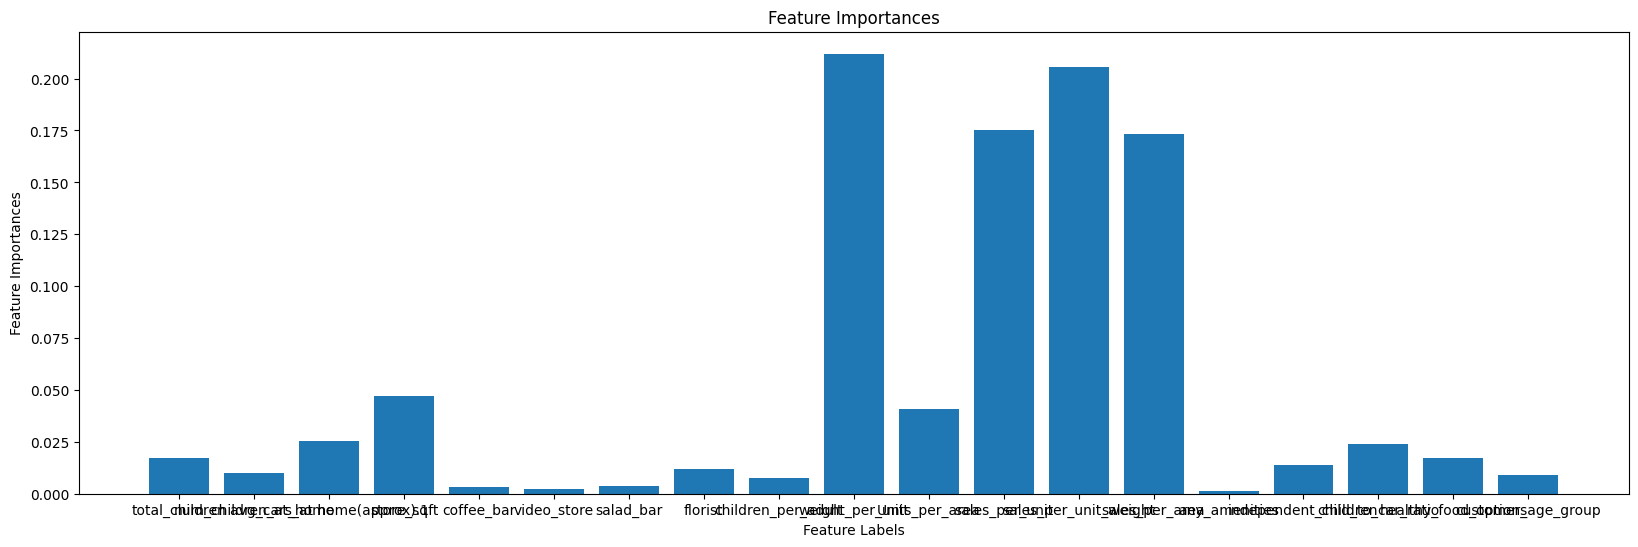

In [ ]:
feature_importance = ex_tree_reg.feature_importances_
plt.figure(figsize = (20, 6))
plt.bar(names, feature_importance)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Feature Importances')
plt.show()

### Parameter Optimisation using Optuna

In [ ]:
def objective_ex_tree(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), # minimum number of samples required to split an internal node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), # minimum number of samples required to be at a leaf node
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    ex_tree_reg_opt = ExtraTreesRegressor(**params, random_state = RANDOM_STATE)
    ex_tree_reg_opt.fit(X_train, y_train)
    y_pred = ex_tree_reg_opt.predict(X_test)

    return rmsle(y_test, y_pred)

#### Ignore

In [ ]:
# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective_ex_tree, n_trials = 30)

[I 2024-04-07 12:15:31,522] A new study created in memory with name: no-name-fe9d2aa9-3ed2-45c5-9c4f-444333e72fd0
[I 2024-04-07 12:17:28,401] Trial 0 finished with value: 0.30815236266298474 and parameters: {'n_estimators': 495, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.30815236266298474.
[I 2024-04-07 12:19:33,093] Trial 1 finished with value: 0.31260259799402207 and parameters: {'n_estimators': 662, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.30815236266298474.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[I 2024-04-07 12:29:34,462] Trial

In [ ]:
# print('Best hyperparameters:', study.best_params)

# RMSLE['Extra Trees Optimised'] = study.best_value
# print('Best RMSLE:', RMSLE['Extra Trees Optimised'])

Best hyperparameters: {'n_estimators': 267, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'auto'}
Best RMSLE: 0.2980603227451805


In [ ]:
# RMSLE

{'Cat Boost': 0.3016560897966655,
 'Cat Boost Optimised': 0.30036001410451607,
 'Extra Trees': 0.3348650647677136,
 'Extra Trees Optimised': 0.2980603227451805}

#### Do not Ignore?

In [ ]:
start = time.time()

sampler = optuna.samplers.TPESampler(seed = RANDOM_STATE)
study = optuna.create_study(direction = 'minimize')
study.optimize(objective_ex_tree, n_trials = 30)

end = time.time()

[I 2024-04-17 16:23:58,864] A new study created in memory with name: no-name-108e2656-ef43-4725-b3bb-772e4901796b
[I 2024-04-17 16:25:06,144] Trial 0 finished with value: 0.3026232617411362 and parameters: {'n_estimators': 244, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.3026232617411362.
[I 2024-04-17 16:26:26,610] Trial 1 finished with value: 0.31546222527379725 and parameters: {'n_estimators': 713, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.3026232617411362.
[I 2024-04-17 16:30:28,345] Trial 2 finished with value: 0.3022958879324183 and parameters: {'n_estimators': 900, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.3022958879324183.
[I 2024-04-17 16:33:18,426] Trial 3 finished with value: 0.30890264780420507 and parameters: {'n_estimators': 827, 'max_depth': 10,

In [ ]:
print('Best hyperparameters:', study.best_params)

RMSLE['Extra Trees Optimised'] = study.best_value
print('Best RMSLE:', RMSLE['Extra Trees Optimised'])

time_elapsed['Extra Trees Optimisation'] = end - start
print('Optimisation time = ', time_elapsed['Extra Trees Optimisation'])

Best hyperparameters: {'n_estimators': 371, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'auto'}
Best RMSLE: 0.29815828130081523
Optimisation time =  7448.675325393677


## Ensembles

In [ ]:
params_rf = {'n_estimators': 171, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}
# params_cat = {'learning_rate': 0.05989207530082648, 'depth': 10, 'subsample': 0.4978884352423685, 'colsample_bylevel': 0.14232096507723183, 'min_data_in_leaf': 47}
# params_cat = {'learning_rate': 0.03021359815512453, 'depth': 10, 'subsample': 0.7839650830622755, 'colsample_bylevel': 0.3215525807872418, 'min_data_in_leaf': 77}
params_cat = {'learning_rate': 0.03636496088030985, 'depth': 10, 'subsample': 0.9101891571476397, 'colsample_bylevel': 0.8702745168751342, 'min_data_in_leaf': 47}
# params_extra = {'n_estimators': 267, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'auto'}
params_extra = {'n_estimators': 371, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 9}

In [ ]:
RMSLE = {'Cat Boost': 0.3016883849146624,
         'Cat Boost Optimised': 0.2998202755463774,
         'Extra Trees': 0.3348650647677136,
         'Extra Trees Optimised': 0.29815828130081523}

time_elapsed = {'CatBoost': 60.04142451286316,
                 'CatBoost Optimisation': 2168.0884881019592,
                 'Extra Trees': 166.5389232635498,
                 'Extra Trees Optimisation': 7448.675325393677}

### Linear Combination

In [ ]:
def linear_combination(weights):
    start = time.time()

    lin = LinearRegression()
    lasso = Lasso(alpha = 0.001)
    ridge = Ridge(alpha = 100)
    rf = RandomForestRegressor(**params_rf, random_state = RANDOM_STATE)
    # xgbm = xgb.XGBRegressor(**params_xgb, eval_metric = 'auc', random_state = 42)
    # lgbm = LGBMRegressor(**params_lgb, random_state = RANDOM_STATE, verbosity = -1)
    cat = CatBoostRegressor(**params_cat, silent = True, random_state = RANDOM_STATE)
    extra = ExtraTreesRegressor(**params_extra, random_state = RANDOM_STATE)

    # Linear Combination
    # regs = [lin, lasso, ridge, rf, xgbm, lgbm, cat, extra]
    regs = [lin, lasso, ridge, rf, cat, extra]
    y_pred = 0

    for i, reg in enumerate(regs):
        if weights[i] == 0:
            continue
        y_pred += weights[i] * reg.fit(X_train, y_train).predict(X_test)

    error = rmsle(y_test, y_pred)
    print('RMSLE: ', error)

    end = time.time()

    print(f'Time elapsed for linear combination = {end - start} seconds')
    return error, end - start

In [ ]:
weights = [0] * 3 + [1 / 3] * 3
RMSLE['Linear Combination (rf, cat_b, extra trees)'], time_elapsed['Linear Combination (rf, cat_b, extra trees)'] = linear_combination(weights)

RMSLE:  0.2985704745298695
Time elapsed for linear combination = 832.120020866394 seconds


In [ ]:
print(RMSLE)
print(time_elapsed)

{'Cat Boost': 0.3016883849146624, 'Cat Boost Optimised': 0.2998202755463774, 'Extra Trees': 0.3348650647677136, 'Extra Trees Optimised': 0.29815828130081523, 'Linear Combination (rf, cat_b, extra trees)': 0.2985704745298695}
{'CatBoost': 60.04142451286316, 'CatBoost Optimisation': 2168.0884881019592, 'Extra Trees': 166.5389232635498, 'Extra Trees Optimisation': 7448.675325393677, 'Linear Combination (rf, cat_b, extra trees)': 832.120020866394}


#### Ignore

In [ ]:
# weights = [1 / 6] * 6
# RMSLE['Linear Combination'], time_elapsed['Linear Combination'] = linear_combination(weights)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSLE:  0.30462878480207023
Time elapsed for linear combination = 790.8572113513947 seconds


In [ ]:
# weights = [0] + [1 / 5] * 5
# RMSLE['Linear Combination (no lin)'], time_elapsed['Linear Combination (no lin)'] = linear_combination(weights)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSLE:  0.30284773149471655
Time elapsed for linear combination = 792.8154602050781 seconds


In [ ]:
# weights = [1 / 5, 0] + [1 / 5] * 4
# RMSLE['Linear Combination (no lasso)'], time_elapsed['Linear Combination (no lasso)'] = linear_combination(weights)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSLE:  0.30284523953575676
Time elapsed for linear combination = 770.424551486969 seconds


In [ ]:
# weights = [1 / 5, 1 / 5, 0] + [1 / 5] * 3
# RMSLE['Linear Combination (no ridge)'], time_elapsed['Linear Combination (no ridge)'] = linear_combination(weights)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSLE:  0.30284998968790927
Time elapsed for linear combination = 759.4281792640686 seconds


In [ ]:
# weights = [1 / 5] * 3 + [0, 1 / 5, 1 / 5]
# RMSLE['Linear Combination (no rf)'], time_elapsed['Linear Combination (no rf)'] = linear_combination(weights)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSLE:  0.30678587307490107
Time elapsed for linear combination = 406.51861810684204 seconds


In [ ]:
# weights = [1 / 5] * 4 + [0, 1 / 5]
# RMSLE['Linear Combination (no cat_b)'], time_elapsed['Linear Combination (no cat_b)'] = linear_combination(weights)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSLE:  0.3062203147262859
Time elapsed for linear combination = 693.2698171138763 seconds


In [ ]:
# weights = [1 / 5] * 5 + [0]
# RMSLE['Linear Combination (no extra trees)'], time_elapsed['Linear Combination (no extra trees)'] = linear_combination(weights)

RMSLE:  0.3070995891179781
Time elapsed for linear combination = 449.50268602371216 seconds


In [ ]:
# RMSLE

{'Cat Boost': 0.3016560897966655,
 'Cat Boost Optimised': 0.29999309023284454,
 'Extra Trees': 0.3348650647677136,
 'Extra Trees Optimised': 0.29814220048032,
 'Linear Combination': 0.30462878480207023,
 'Linear Combination (no lin)': 0.30284773149471655,
 'Linear Combination (no lasso)': 0.30284523953575676,
 'Linear Combination (no ridge)': 0.30284998968790927,
 'Linear Combination (no rf)': 0.30678587307490107,
 'Linear Combination (no cat_b)': 0.3062203147262859,
 'Linear Combination (no extra trees)': 0.3070995891179781,
 'Linear Combination (last 3)': 0.2985058912685392}

In [ ]:
# time_elapsed

{'CatBoost': 83.53459191322327,
 'CatBoost Optimisation': 1667.3058681488037,
 'Extra Trees': 170.46712589263916,
 'Extra Trees Optimisation': 8600.372066736221,
 'Linear Combination': 790.8572113513947,
 'Linear Combination (no lin)': 792.8154602050781,
 'Linear Combination (no lasso)': 770.424551486969,
 'Linear Combination (no ridge)': 759.4281792640686,
 'Linear Combination (no rf)': 406.51861810684204,
 'Linear Combination (no cat_b)': 693.2698171138763,
 'Linear Combination (no extra trees)': 449.50268602371216,
 'Linear Combination (last 3)': 820.9398219585419}

In [ ]:
# def objective_lin_combo(weights):
#     lin = LinearRegression()
#     lasso = Lasso(alpha = 0.001)
#     ridge = Ridge(alpha = 100)
#     rf = RandomForestRegressor(**params_rf, random_state = 42)
#     # xgbm = xgb.XGBRegressor(**params_xgb, eval_metric = 'auc', random_state = 42)
#     # lgbm = LGBMRegressor(**params_lgb, random_state = 42, verbosity = -1)
#     cat = CatBoostRegressor(**params_cat, silent = True)
#     extra = ExtraTreesRegressor(**params_extra)

#     # Linear Combination
#     # regs = [lin, lasso, ridge, rf, xgbm, lgbm, cat, extra]
#     regs = [lin, lasso, ridge, rf, cat, extra]
#     y_pred = 0

#     for i, reg in enumerate(regs):
#         if weights[i] == 0:
#             continue
#         y_pred += weights[i] * reg.fit(X_train, y_train).predict(X_test)

#     return rmsle(y_test, y_pred)

# param_grid = {
#     'weights': [(w1, w2, w3, w4, w5, w6) for w1 in np.linspace(0, 1, 6)
#                 for w2 in np.linspace(0, 1, 6)
#                 for w3 in np.linspace(0, 1, 6)
#                 for w4 in np.linspace(0, 1, 6)
#                 for w5 in np.linspace(0, 1, 6)
#                 for w6 in np.linspace(0, 1, 6)
#                 if w1 + w2 + w3 + w4 + w5 + w6 == 1]
# }

# grid_search = GridSearchCV(estimator = None, param_grid = param_grid, cv = 3, scoring = make_scorer(rmsle, greater_is_better = False))
# grid_search.fit(X_train, y_train)

# best_weights = grid_search.best_params_['weights']
# print('Best weights: ', best_weights)

### Stacking

In [ ]:
start = time.time()

estimators = [
        ('rf', RandomForestRegressor(**params_rf, random_state = RANDOM_STATE)),
        ('extra_trees', ExtraTreesRegressor(**params_extra, random_state = RANDOM_STATE))
        ]
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = CatBoostRegressor(**params_cat, random_state = RANDOM_STATE, silent = True)
    )
y_pred = reg.fit(X_train, y_train).predict(X_test)
RMSLE['Stacking ((rf + extra_trees) + cat_b)'] = rmsle(y_test, y_pred)

end = time.time()

time_elapsed['Stacking ((rf + extra_trees) + cat_b)'] = end - start

print('RMSLE Stacking = ', RMSLE['Stacking ((rf + extra_trees) + cat_b)'])
print(f'Time elapsed for stacking = {end - start} seconds')

RMSLE Stacking =  0.29829720857114916
Time elapsed for stacking = 3582.1030898094177 seconds


#### Ignore

In [ ]:
# estimators = [
#         ('lin_reg', LinearRegression()),
#         ('lasso_reg', Lasso(alpha = 0.001)),
#         ('ridge_reg', Ridge(alpha = 100)),
#         ('rf', RandomForestRegressor(**params_rf, random_state = RANDOM_STATE)),
#         ('cat_boost', CatBoostRegressor(**params_cat, random_state = RANDOM_STATE, silent = True))
#         ]
# reg = StackingRegressor(
#     estimators = estimators,
#     final_estimator = ExtraTreesRegressor(**params_extra, random_state = RANDOM_STATE)
#     )
# y_pred = reg.fit(X_train, y_train).predict(X_test)
# print('RMSLE Stacking = ', rmsle(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSLE Stacking =  0.29869544908687556


In [ ]:
# RMSLE['Stacking 1'] = rmsle(y_test, y_pred)
# RMSLE

{'Cat Boost': 0.3016883849146624,
 'Cat Boost Optimised': 0.2998202755463774,
 'Extra Trees': 0.3348650647677136,
 'Extra Trees Optimised': 0.29815828130081523,
 'Stacking 1': 0.29869544908687556}

In [ ]:
# estimators = [
#         ('lin_reg', LinearRegression()),
#         ('lasso_reg', Lasso(alpha = 0.001)),
#         ('ridge_reg', Ridge(alpha = 100)),
#         ('rf', RandomForestRegressor(**params_rf, random_state = RANDOM_STATE)),
#         ('extra_trees', ExtraTreesRegressor(**params_extra, random_state = RANDOM_STATE))
#         ]
# reg = StackingRegressor(
#     estimators = estimators,
#     final_estimator = CatBoostRegressor(**params_cat, random_state = RANDOM_STATE, silent = True)
#     )
# y_pred = reg.fit(X_train, y_train).predict(X_test)
# RMSLE['Stacking 2'] = rmsle(y_test, y_pred)
# print('RMSLE Stacking = ', RMSLE['Stacking 2'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RMSLE Stacking =  0.2982265334130268


In [ ]:
# estimators = [
#         ('lin_reg', LinearRegression()),
#         ('lasso_reg', Lasso(alpha = 0.001)),
#         ('ridge_reg', Ridge(alpha = 100)),
#         ('cat_boost', CatBoostRegressor(**params_cat, random_state = RANDOM_STATE, silent = True)),
#         ('extra_trees', ExtraTreesRegressor(**params_extra, random_state = RANDOM_STATE))
#         ]
# reg = StackingRegressor(
#     estimators = estimators,
#     final_estimator = RandomForestRegressor(**params_rf, random_state = RANDOM_STATE)
#     )
# y_pred = reg.fit(X_train, y_train).predict(X_test)
# RMSLE['Stacking 3'] = rmsle(y_test, y_pred)
# print('RMSLE Stacking = ', RMSLE['Stacking 3'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RMSLE Stacking =  0.2982434510829694


# Submission

In [ ]:
RMSLE

{'Cat Boost': 0.3016883849146624,
 'Cat Boost Optimised': 0.2998202755463774,
 'Extra Trees': 0.3348650647677136,
 'Extra Trees Optimised': 0.29815828130081523,
 'Linear Combination (rf, cat_b, extra trees)': 0.2985704745298695,
 'Stacking ((rf + extra_trees) + cat_b)': 0.29829720857114916}

In [ ]:
time_elapsed

{'CatBoost': 60.04142451286316,
 'CatBoost Optimisation': 2168.0884881019592,
 'Extra Trees': 166.5389232635498,
 'Extra Trees Optimisation': 7448.675325393677,
 'Linear Combination (rf, cat_b, extra trees)': 832.120020866394,
 'Stacking ((rf + extra_trees) + cat_b)': 3582.1030898094177}

In [ ]:
RMSLE_df = pd.DataFrame(RMSLE.items(), columns = ['model', 'RMSLE'])
RMSLE_df

model     RMSLE
0                                    Cat Boost  0.301688
1                          Cat Boost Optimised  0.299820
2                                  Extra Trees  0.334865
3                        Extra Trees Optimised  0.298158
4  Linear Combination (rf, cat_b, extra trees)  0.298570
5        Stacking ((rf + extra_trees) + cat_b)  0.298297

In [ ]:
RMSLE_df.to_csv('drive/MyDrive/SC4000/RMSLE.csv', index = False)

In [ ]:
time_df = pd.DataFrame(time_elapsed.items(), columns = ['model', 'time elapsed (seconds)'])
time_df

model  time elapsed (seconds)
0                                     CatBoost               60.041425
1                        CatBoost Optimisation             2168.088488
2                                  Extra Trees              166.538923
3                     Extra Trees Optimisation             7448.675325
4  Linear Combination (rf, cat_b, extra trees)              832.120021
5        Stacking ((rf + extra_trees) + cat_b)             3582.103090

In [ ]:
time_df.to_csv('drive/MyDrive/SC4000/time_elapsed.csv', index = False)

In [ ]:
final_model = ExtraTreesRegressor(**params_extra, random_state = RANDOM_STATE)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_)
y_pred

array([ 99.20693233,  96.75196514,  94.38671886, ...,  98.47102154,
       110.57476559, 109.75625869])

In [ ]:
export = np.hstack((np.reshape(test_df['id'].values, (-1,1)), np.reshape(y_pred, (-1,1))))
submission = pd.DataFrame(export, columns = ['id', 'cost'])
submission.to_csv(r'drive/MyDrive/SC4000/submission.csv', index = False, header = ['id', 'cost'])
submission.shape

(240224, 2)

In [ ]:
import pickle

model_pkl_file = 'drive/MyDrive/SC4000/extra_trees_optimised.pkl'

with open(model_pkl_file, 'wb') as file:
    pickle.dump(final_model, file)

# Neural Network

In [ ]:
train

total_children num_children_at_home avg_cars_at home(approx).1  \
0                 2.0                  2.0                        2.0   
1                 4.0                  0.0                        3.0   
2                 0.0                  0.0                        3.0   
3                 5.0                  0.0                        0.0   
4                 5.0                  0.0                        3.0   
...               ...                  ...                        ...   
360331            5.0                  5.0                        3.0   
360332            4.0                  0.0                        4.0   
360333            0.0                  0.0                        2.0   
360334            1.0                  0.0                        3.0   
360335            2.0                  0.0                        2.0   

       store_sqft coffee_bar video_store salad_bar florist children_per_adult  \
0        0.835527          0           0         0       0                1.0   
1        0.407029          1           0         0       0                0.0   
2         0.04624          1           0         0       0                0.0   
3         0.04624          1           0         0       0                0.0   
4        0.380606          1           1         1       1                0.0   
...           ...        ...         ...       ...     ...                ...   
360331   0.513444          0           0         0       0                1.0   
360332        0.0          0           0         0       0                0.0   
360333   0.529752          1           1         1       1                0.0   
360334   0.529752          1           1         1       1                0.0   
360335   0.698715          1           0         1       1                0.0   

       weight_per_unit  ... independent_children child_to_car_ratio  \
0             3.433333  ...                  0.0                1.0   
1                 3.33  ...                  4.0           1.333333   
2                5.325  ...                  0.0                0.0   
3             4.933333  ...                  5.0               10.0   
4             5.666667  ...                  5.0           1.666667   
...                ...  ...                  ...                ...   
360331           3.375  ...                  0.0           1.666667   
360332             4.7  ...                  4.0                1.0   
360333        3.766667  ...                  0.0                0.0   
360334             3.4  ...                  1.0           0.333333   
360335             5.4  ...                  2.0                1.0   

       healthy_food_options customer_age_group children_per_adult  \
0                         0                1.0                1.0   
1                         0               10.0                0.0   
2                         0                0.0                0.0   
3                         0               10.0                0.0   
4                         1               10.0                0.0   
...                     ...                ...                ...   
360331                    0                1.0                1.0   
360332                    0               10.0                0.0   
360333                    0                0.0                0.0   
360334                    1               10.0                0.0   
360335                    0               10.0                0.0   

       independent_children customer_age_group any_amenities  \
0                       0.0                1.0         False   
1                       4.0               10.0          True   
2                       0.0                0.0          True   
3                       5.0               10.0          True   
4                       5.0               10.0          True   
...                     ...                ...           ...   
360331                  0.0

In [ ]:
train.shape

(360336, 25)

In [ ]:
test

total_children num_children_at_home avg_cars_at home(approx).1  \
0                 1.0                  0.0                        2.0   
1                 2.0                  2.0                        3.0   
2                 0.0                  0.0                        3.0   
3                 3.0                  3.0                        2.0   
4                 2.0                  0.0                        2.0   
...               ...                  ...                        ...   
240219            0.0                  0.0                        1.0   
240220            2.0                  0.0                        4.0   
240221            0.0                  0.0                        3.0   
240222            0.0                  0.0                        2.0   
240223            1.0                  1.0                        4.0   

       store_sqft coffee_bar video_store salad_bar florist children_per_adult  \
0             0.0          0           0         0       0                0.0   
1        0.698715          1           0         1       1                1.0   
2             1.0          0           0         1       0                0.0   
3        0.173866          1           1         1       1                1.0   
4        0.380606          1           1         1       1                0.0   
...           ...        ...         ...       ...     ...                ...   
240219   0.932188          0           0         0       0                0.0   
240220   0.513444          0           0         0       0                0.0   
240221        1.0          0           0         1       0                0.0   
240222    0.17753          1           0         1       1                0.0   
240223   0.168963          0           0         0       0                1.0   

       weight_per_unit  ... independent_children child_to_car_ratio  \
0                  2.7  ...                  1.0                0.5   
1                4.255  ...                  0.0           0.666667   
2             2.923333  ...                  0.0                0.0   
3                10.95  ...                  0.0                1.5   
4             3.633333  ...                  2.0                1.0   
...                ...  ...                  ...                ...   
240219          2.0975  ...                  0.0                0.0   
240220            3.94  ...                  2.0                0.5   
240221        3.833333  ...                  0.0                0.0   
240222           4.165  ...                  0.0                0.0   
240223        3.333333  ...                  0.0               0.25   

       healthy_food_options customer_age_group children_per_adult  \
0                         0               10.0                0.0   
1                         0                1.0                1.0   
2                         1                0.0                0.0   
3                         0                1.0                1.0   
4                         0               10.0                0.0   
...                     ...                ...                ...   
240219                    0                0.0                0.0   
240220                    0               10.0                0.0   
240221                    0                0.0                0.0   
240222                    0                0.0                0.0   
240223                    0                1.0                1.0   

       independent_children customer_age_group any_amenities  \
0                       1.0               10.0         False   
1                       0.0                1.0          True   
2                       0.0                0.0          True   
3                       0.0                1.0          True   
4                       2.0               10.0          True   
...                     ...                ...           ...   
240219                  0.0

In [ ]:
test.shape

(240224, 25)

In [ ]:
test = test.drop(columns = [None])
test

total_children num_children_at_home avg_cars_at home(approx).1  \
0                 1.0                  0.0                        2.0   
1                 2.0                  2.0                        3.0   
2                 0.0                  0.0                        3.0   
3                 3.0                  3.0                        2.0   
4                 2.0                  0.0                        2.0   
...               ...                  ...                        ...   
240219            0.0                  0.0                        1.0   
240220            2.0                  0.0                        4.0   
240221            0.0                  0.0                        3.0   
240222            0.0                  0.0                        2.0   
240223            1.0                  1.0                        4.0   

       store_sqft coffee_bar video_store salad_bar florist children_per_adult  \
0             0.0          0           0         0       0                0.0   
1        0.698715          1           0         1       1                1.0   
2             1.0          0           0         1       0                0.0   
3        0.173866          1           1         1       1                1.0   
4        0.380606          1           1         1       1                0.0   
...           ...        ...         ...       ...     ...                ...   
240219   0.932188          0           0         0       0                0.0   
240220   0.513444          0           0         0       0                0.0   
240221        1.0          0           0         1       0                0.0   
240222    0.17753          1           0         1       1                0.0   
240223   0.168963          0           0         0       0                1.0   

       weight_per_unit  ... any_amenities independent_children  \
0                  2.7  ...         False                  1.0   
1                4.255  ...          True                  0.0   
2             2.923333  ...          True                  0.0   
3                10.95  ...          True                  0.0   
4             3.633333  ...          True                  2.0   
...                ...  ...           ...                  ...   
240219          2.0975  ...         False                  0.0   
240220            3.94  ...         False                  2.0   
240221        3.833333  ...          True                  0.0   
240222           4.165  ...          True                  0.0   
240223        3.333333  ...         False                  0.0   

       child_to_car_ratio healthy_food_options customer_age_group  \
0                     0.5                    0               10.0   
1                0.666667                    0                1.0   
2                     0.0                    1                0.0   
3                     1.5                    0                1.0   
4                     1.0                    0               10.0   
...                   ...                  ...                ...   
240219                0.0                    0                0.0   
240220                0.5                    0               10.0   
240221                0.0                    0                0.0   
240222                0.0                    0                0.0   
240223               0.25                    0                1.0   

       children_per_adult independent_children customer_age_group  \
0                     0.0                  1.0               10.0   
1                     1.0                  0.0                1.0   
2                     0.0                  0.0                0.0   
3                     1.0                  0.0                1.0   
4                     0.0                  2.0               10.0   
...                   ...                  ...                ...   
240219                0.0                  0.0      

In [ ]:
train.dtypes

total_children                object
num_children_at_home          object
avg_cars_at home(approx).1    object
store_sqft                    object
coffee_bar                    object
video_store                   object
salad_bar                     object
florist                       object
children_per_adult            object
weight_per_unit               object
Units_per_area                object
sales_per_unit                object
sales_per_unit_weight         object
sales_per_area                object
any_amenities                 object
independent_children          object
child_to_car_ratio            object
healthy_food_options          object
customer_age_group            object
children_per_adult            object
independent_children          object
customer_age_group            object
any_amenities                 object
child_to_car_ratio            object
cost                          object
dtype: object

In [ ]:
for column in train.columns:
    print(f'{column} = {train.iloc[0][column]}')

total_children = 2.0
num_children_at_home = 2.0
avg_cars_at home(approx).1 = 2.0
store_sqft = 0.8355266553129999
coffee_bar = 0
video_store = 0
salad_bar = 0
florist = 0
children_per_adult = children_per_adult    1.0
children_per_adult    1.0
Name: 0, dtype: object
weight_per_unit = 3.4333333333333336
Units_per_area = 8.217151935139281e-05
sales_per_unit = 2.8699999999999997
sales_per_unit_weight = 0.8359223300970873
sales_per_area = 0.00023583226053849735
any_amenities = any_amenities    False
any_amenities    False
Name: 0, dtype: object
independent_children = independent_children    0.0
independent_children    0.0
Name: 0, dtype: object
child_to_car_ratio = child_to_car_ratio    1.0
child_to_car_ratio    1.0
Name: 0, dtype: object
healthy_food_options = 0
customer_age_group = customer_age_group    1.0
customer_age_group    1.0
Name: 0, dtype: object
children_per_adult = children_per_adult    1.0
children_per_adult    1.0
Name: 0, dtype: object
independent_children = independent_chil

In [ ]:
train = train.loc[:,~train.columns.duplicated()].copy()
train

total_children num_children_at_home avg_cars_at home(approx).1  \
0                 2.0                  2.0                        2.0   
1                 4.0                  0.0                        3.0   
2                 0.0                  0.0                        3.0   
3                 5.0                  0.0                        0.0   
4                 5.0                  0.0                        3.0   
...               ...                  ...                        ...   
360331            5.0                  5.0                        3.0   
360332            4.0                  0.0                        4.0   
360333            0.0                  0.0                        2.0   
360334            1.0                  0.0                        3.0   
360335            2.0                  0.0                        2.0   

       store_sqft coffee_bar video_store salad_bar florist children_per_adult  \
0        0.835527          0           0         0       0                1.0   
1        0.407029          1           0         0       0                0.0   
2         0.04624          1           0         0       0                0.0   
3         0.04624          1           0         0       0                0.0   
4        0.380606          1           1         1       1                0.0   
...           ...        ...         ...       ...     ...                ...   
360331   0.513444          0           0         0       0                1.0   
360332        0.0          0           0         0       0                0.0   
360333   0.529752          1           1         1       1                0.0   
360334   0.529752          1           1         1       1                0.0   
360335   0.698715          1           0         1       1                0.0   

       weight_per_unit Units_per_area sales_per_unit sales_per_unit_weight  \
0             3.433333       0.000082           2.87              0.835922   
1                 3.33       0.000071            2.5              0.750751   
2                5.325       0.000189           3.52              0.661033   
3             4.933333       0.000141           1.34              0.271622   
4             5.666667       0.000108           0.71              0.125294   
...                ...            ...            ...                   ...   
360331           3.375       0.000132            1.9              0.562963   
360332             4.7       0.000197           3.61              0.768085   
360333        3.766667       0.000098           3.58              0.950442   
360334             3.4       0.000098           3.68              1.082353   
360335             5.4       0.000059           2.65              0.490741   

       sales_per_area any_amenities independent_children child_to_car_ratio  \
0            0.000236         False                  0.0                1.0   
1            0.000177          True                  4.0           1.333333   
2            0.000664          True                  0.0                0.0   
3            0.000189          True                  5.0               10.0   
4            0.000077          True                  5.0           1.666667   
...               ...           ...                  ...                ...   
360331       0.000251         False                  0.0           1.666667   
360332       0.000711         False                  4.0                1.0   
360333       0.000351          True                  0.0                0.0   
360334       0.000361          True                  1.0           0.333333   
360335       0.000157          True                  2.0                1.0   

       healthy_food_options customer_age_group    cost  
0                         0                1.0   62.09  
1                         0               10.0   121.8  
2                         0                0.0   83.51  
3                         0               1

In [ ]:
train.columns

Index(['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1',
       'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'florist',
       'children_per_adult', 'weight_per_unit', 'Units_per_area',
       'sales_per_unit', 'sales_per_unit_weight', 'sales_per_area',
       'any_amenities', 'independent_children', 'child_to_car_ratio',
       'healthy_food_options', 'customer_age_group', 'cost'],
      dtype='object')

In [ ]:
for column in train.columns:
    print(f'{column} = {train.iloc[0][column]}')

total_children = 2.0
num_children_at_home = 2.0
avg_cars_at home(approx).1 = 2.0
store_sqft = 0.8355266553129999
coffee_bar = 0
video_store = 0
salad_bar = 0
florist = 0
children_per_adult = 1.0
weight_per_unit = 3.4333333333333336
Units_per_area = 8.217151935139281e-05
sales_per_unit = 2.8699999999999997
sales_per_unit_weight = 0.8359223300970873
sales_per_area = 0.00023583226053849735
any_amenities = False
independent_children = 0.0
child_to_car_ratio = 1.0
healthy_food_options = 0
customer_age_group = 1.0
cost = 62.09


In [ ]:
for column in train.columns:
    print(f'{column} = {train[column].value_counts().index.tolist()}')

total_children = [1.0, 2.0, 3.0, 4.0, 0.0, 5.0]
num_children_at_home = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
avg_cars_at home(approx).1 = [2.0, 3.0, 1.0, 4.0, 0.0]
store_sqft = [0.04624038808897146, 0.380605872942148, 0.6987149713577954, 0.16922124167827834, 0.0, 0.5134437735459565, 0.5407441812458069, 1.0, 0.14413995974609084, 0.7468648397584765, 0.9321876451463074, 0.17386592351757235, 0.17753006141301553, 0.5297517675594776, 0.16896320379831753, 0.8355266553129999, 0.11142075656706396, 0.40702895185013155, 0.7293698714971357, 0.22077721009444184]
coffee_bar = [1, 0]
video_store = [0, 1]
salad_bar = [1, 0]
florist = [1, 0]
children_per_adult = [0.0, 1.0, 0.5, 0.3333333333333333, 0.6666666666666666, 0.25, 0.75, 0.2, 0.6, 0.4, 0.8, 1.3333333333333333, 1.5]
weight_per_unit = [5.7, 5.3, 5.2, 4.5, 3.4, 5.0, 3.5, 4.0, 3.6, 7.3, 4.8999999999999995, 6.633333333333333, 5.733333333333333, 5.366666666666667, 5.5, 6.2, 4.566666666666666, 7.0, 5.8, 6.433333333333334, 4.3999999999999995, 6.23333333333333

In [ ]:
test = test.loc[:,~test.columns.duplicated()].copy()
test

total_children num_children_at_home avg_cars_at home(approx).1  \
0                 1.0                  0.0                        2.0   
1                 2.0                  2.0                        3.0   
2                 0.0                  0.0                        3.0   
3                 3.0                  3.0                        2.0   
4                 2.0                  0.0                        2.0   
...               ...                  ...                        ...   
240219            0.0                  0.0                        1.0   
240220            2.0                  0.0                        4.0   
240221            0.0                  0.0                        3.0   
240222            0.0                  0.0                        2.0   
240223            1.0                  1.0                        4.0   

       store_sqft coffee_bar video_store salad_bar florist children_per_adult  \
0             0.0          0           0         0       0                0.0   
1        0.698715          1           0         1       1                1.0   
2             1.0          0           0         1       0                0.0   
3        0.173866          1           1         1       1                1.0   
4        0.380606          1           1         1       1                0.0   
...           ...        ...         ...       ...     ...                ...   
240219   0.932188          0           0         0       0                0.0   
240220   0.513444          0           0         0       0                0.0   
240221        1.0          0           0         1       0                0.0   
240222    0.17753          1           0         1       1                0.0   
240223   0.168963          0           0         0       0                1.0   

       weight_per_unit Units_per_area sales_per_unit sales_per_unit_weight  \
0                  2.7       0.000197           1.81               0.67037   
1                4.255       0.000059           3.45              0.810811   
2             2.923333       0.000076           2.78              0.950969   
3                10.95       0.000084           2.74              0.250228   
4             3.633333       0.000108            1.6              0.440367   
...                ...            ...            ...                   ...   
240219          2.0975       0.000104           2.15               1.02503   
240220            3.94       0.000066           2.15              0.545685   
240221        3.833333       0.000076            2.1              0.547826   
240222           4.165       0.000084           3.97              0.953181   
240223        3.333333       0.000127           2.52                 0.756   

       sales_per_area any_amenities independent_children child_to_car_ratio  \
0            0.000356         False                  1.0                0.5   
1            0.000204          True                  0.0           0.666667   
2             0.00021          True                  0.0                0.0   
3            0.000231          True                  0.0                1.5   
4            0.000173          True                  2.0                1.0   
...               ...           ...                  ...                ...   
240219       0.000224         False                  0.0                0.0   
240220       0.000142         False                  2.0                0.5   
240221       0.000159          True                  0.0                0.0   
240222       0.000334          True                  0.0                0.0   
240223        0.00032         False                  0.0               0.25   

       healthy_food_options customer_age_group  
0                         0               10.0  
1                         0                1.0  
2                         1                0.0  
3                         0                1.0  
4                         

In [ ]:
!pip install pytorch_tabular[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x

In [ ]:
import pandas as pd

from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig, GANDALFConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

In [ ]:
train_cols = selected_features + ['log_cost']
train = train_df[train_cols]
train

total_children  num_children_at_home  avg_cars_at home(approx).1  \
0                  2.0                   2.0                         2.0   
1                  4.0                   0.0                         3.0   
2                  0.0                   0.0                         3.0   
3                  5.0                   0.0                         0.0   
4                  5.0                   0.0                         3.0   
...                ...                   ...                         ...   
360331             5.0                   5.0                         3.0   
360332             4.0                   0.0                         4.0   
360333             0.0                   0.0                         2.0   
360334             1.0                   0.0                         3.0   
360335             2.0                   0.0                         2.0   

        store_sqft  coffee_bar  video_store  salad_bar  florist  log_cost  
0         0.835527         0.0          0.0        0.0      0.0  4.144562  
1         0.407029         1.0          0.0        0.0      0.0  4.810557  
2         0.046240         1.0          0.0        0.0      0.0  4.436870  
3         0.046240         1.0          0.0        0.0      0.0  4.216267  
4         0.380606         1.0          1.0        1.0      1.0  4.723042  
...            ...         ...          ...        ...      ...       ...  
360331    0.513444         0.0          0.0        0.0      0.0  4.900969  
360332    0.000000         0.0          0.0        0.0      0.0  4.417032  
360333    0.529752         1.0          1.0        1.0      1.0  4.478132  
360334    0.529752         1.0          1.0        1.0      1.0  4.995319  
360335    0.698715         1.0          0.0        1.0      1.0  4.815998  

[360336 rows x 9 columns]

In [ ]:
train, val = train_test_split(train, test_size = 0.2, random_state = RANDOM_STATE)

In [ ]:
train

total_children  num_children_at_home  avg_cars_at home(approx).1  \
107094             4.0                   2.0                         2.0   
277190             4.0                   0.0                         2.0   
230291             4.0                   4.0                         3.0   
249939             2.0                   0.0                         1.0   
342949             5.0                   0.0                         2.0   
...                ...                   ...                         ...   
119879             2.0                   0.0                         1.0   
259178             3.0                   0.0                         1.0   
131932             2.0                   1.0                         4.0   
146867             5.0                   0.0                         4.0   
121958             2.0                   2.0                         1.0   

        store_sqft  coffee_bar  video_store  salad_bar  florist  log_cost  
107094    0.169221         0.0          0.0        0.0      1.0  4.888920  
277190    0.000000         0.0          0.0        0.0      0.0  4.773139  
230291    0.380606         1.0          1.0        1.0      1.0  4.035832  
249939    0.540744         1.0          1.0        1.0      1.0  4.355169  
342949    0.168963         0.0          0.0        0.0      0.0  4.861362  
...            ...         ...          ...        ...      ...       ...  
119879    0.173866         1.0          1.0        1.0      1.0  4.246207  
259178    0.111421         1.0          0.0        0.0      0.0  4.789989  
131932    0.169221         0.0          0.0        0.0      1.0  4.186012  
146867    0.932188         0.0          0.0        0.0      0.0  4.154812  
121958    0.046240         1.0          0.0        0.0      0.0  4.257455  

[288268 rows x 9 columns]

In [ ]:
val

total_children  num_children_at_home  avg_cars_at home(approx).1  \
332595             5.0                   4.0                         4.0   
139358             1.0                   0.0                         1.0   
284011             2.0                   0.0                         2.0   
248359             0.0                   0.0                         3.0   
304365             1.0                   0.0                         3.0   
...                ...                   ...                         ...   
252332             2.0                   0.0                         2.0   
358695             2.0                   0.0                         4.0   
172392             3.0                   1.0                         2.0   
272639             1.0                   1.0                         2.0   
157458             2.0                   0.0                         1.0   

        store_sqft  coffee_bar  video_store  salad_bar  florist  log_cost  
332595    1.000000         0.0          0.0        1.0      0.0  4.987162  
139358    0.169221         0.0          0.0        0.0      1.0  4.861362  
284011    1.000000         0.0          0.0        1.0      0.0  4.754021  
248359    0.835527         0.0          0.0        0.0      0.0  4.837075  
304365    0.835527         0.0          0.0        0.0      0.0  5.009768  
...            ...         ...          ...        ...      ...       ...  
252332    0.698715         1.0          0.0        1.0      1.0  4.108083  
358695    0.513444         0.0          0.0        0.0      0.0  4.503912  
172392    0.932188         0.0          0.0        0.0      0.0  4.521789  
272639    0.046240         1.0          0.0        0.0      0.0  4.257455  
157458    0.046240         1.0          0.0        0.0      0.0  4.355169  

[72068 rows x 9 columns]

In [ ]:
# num_cols = ['store_sqft', 'children_per_adult', 'weight_per_unit', 'Units_per_area', 'sales_per_unit', 'sales_per_unit_weight', 'sales_per_area',
#             'child_to_car_ratio', 'customer_age_group']
# cat_cols = ['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'coffee_bar', 'video_store', 'salad_bar', 'florist', 'any_amenities',
#             'independent_children', 'healthy_food_options']


data_config = DataConfig(
    target = ['log_cost'],
    categorical_cols = selected_features
)

trainer_config = TrainerConfig(
    auto_lr_find = True,
    batch_size = 1024,
    max_epochs = 50,
    early_stopping = None
)

optimizer_config = OptimizerConfig() # default opimizer = Adam

# model_config = CategoryEmbeddingModelConfig(
#     task = 'regression',
#     layers = '256-128-64',
#     activation = 'ReLU',
# )

model_config = GANDALFConfig(
    task = 'regression',
    gflu_stages = 6,
    gflu_feature_init_sparsity = 0.3,
    gflu_dropout = 0.0,
    learning_rate = 1e-3,
)

tabular_model = TabularModel(
    data_config = data_config,
    model_config = model_config,
    optimizer_config = optimizer_config,
    trainer_config = trainer_config,
)

tabular_model.fit(train = train)
result = tabular_model.evaluate(val)

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task
INFO:pytorch_tabular.tabular_model:Preparing the Model: GANDALFModel
INFO:pytorch_tabular.models.gandalf.gandalf:Data Aware Initialization of T0
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Auto LR Find Started
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not e

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0010964781961431851
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5dd46b04-8d39-41fd-b1a2-e8e0d65be317.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5dd46b04-8d39-41fd-b1a2-e8e0d65be317.ckpt
INFO:pytorch_tabular.tabular_model:Suggested LR: 0.0010964781961431851. For plot and detailed analysis, use `find_learning_rate` method.
INFO:pytorch_tabular.models.gandalf.gandalf:Data Aware Initialization of T0
INFO:pytorch_tabular.tabular_model:Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │ 33.1 K │
│ 1 │ _embedding_layer │ Embedding1dLayer │    329 │
│ 2 │ _head            │ Sequential       │     32 │
│ 3 │ loss             │ MSELoss          │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 33.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 33.5 K                                                                                               
Total estimated model params size (MB): 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.08644606173038483    │
│  test_mean_squared_error  │    0.08644606173038483    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
pred_df = tabular_model.predict(val)
pred_df

log_cost_prediction
332595             4.704501
139358             4.442526
284011             4.534147
248359             4.749203
304365             4.904500
...                     ...
252332             4.504058
358695             4.522386
172392             4.607712
272639             4.615228
157458             4.587090

[72068 rows x 1 columns]

In [ ]:
RMSLE['gandalf 3'] = mean_squared_error(val['log_cost'], pred_df['log_cost_prediction'], squared = False)
print('RMSLE = ', RMSLE['gandalf 3'])

RMSLE =  0.29401711996251406


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
RMSLE

{'CatEmbed': 0.3004390326075823,
 'CatEmbed 2': 0.3046710739576547,
 'gandalf': 0.2972562219585106,
 'gandalf 2': 0.2950353002030181,
 'gandalf 3': 0.29401711996251406}

In [ ]:
# RMSLE['GANDALF'] = rmsle(val['cost'], pred_df['cost_prediction'])
# print('RMSLE = ', RMSLE['GANDALF'])

RMSLE =  0.3198680933651232


In [ ]:
RMSLE

{'Category Embedding': 0.31148566359561514,
 'Category Embedding 128': 0.30554871413304047,
 'Category Embedding 64': 0.3130792490007144,
 'Category Embedding 256': 0.30316070934348466,
 'Category Embedding 256-128-64': 0.303005704171816,
 'GANDALF': 0.3198680933651232}

In [ ]:
%%time
from pytorch_tabular import model_sweep
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sweep_df, best_model = model_sweep(
        task = 'regression',
        train = train,
        test = val,
        data_config = data_config,
        optimizer_config = optimizer_config,
        trainer_config = trainer_config,
        model_list = 'lite',
        metrics = ['mean_squared_error'],
        metrics_params = [{}],
        metrics_prob_input = [False],
        rank_metric = ('mean_squared_error', 'lower_is_better'),
        progress_bar = True,
        verbose = True,
        suppress_lightning_logger = True,
    )

Output()

INFO:pytorch_tabular:Training CategoryEmbeddingModel


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_tabular:Finished Training CategoryEmbeddingModel
INFO:pytorch_tabular:Results: model: CategoryEmbeddingModel, # Params: 50 T, epochs: 16, test_loss: 824.1845092773438, test_mean_squared_error: 824.1845092773438, time_taken: 189.11550211906433, time_taken_per_epoch: 11.81971888244152
INFO:pytorch_tabular:Training GANDALFModel
INFO:pytorch_tabular.models.gandalf.gandalf:Data Aware Initialization of T0


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_tabular.models.gandalf.gandalf:Data Aware Initialization of T0
INFO:pytorch_tabular:Finished Training GANDALFModel
INFO:pytorch_tabular:Results: model: GANDALFModel, # Params: 47 T, epochs: 6, test_loss: 891.5958251953125, test_mean_squared_error: 891.5958251953125, time_taken: 113.3691954612732, time_taken_per_epoch: 18.8948659102122
INFO:pytorch_tabular:Training TabNetModel


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_tabular:Finished Training TabNetModel
INFO:pytorch_tabular:Results: model: TabNetModel, # Params: 50 T, epochs: 7, test_loss: 867.9208374023438, test_mean_squared_error: 867.9208374023438, time_taken: 186.11389088630676, time_taken_per_epoch: 26.587698698043823


INFO:pytorch_tabular:Model Sweep Finished
INFO:pytorch_tabular:Best Model: CategoryEmbeddingModel


CPU times: user 7min 49s, sys: 4.55 s, total: 7min 53s
Wall time: 8min 16s


In [ ]:
sweep_df

model # Params  epochs   test_loss  \
0  CategoryEmbeddingModel     50 T      16  824.184509   
2             TabNetModel     50 T       7  867.920837   
1            GANDALFModel     47 T       6  891.595825   

   test_mean_squared_error  time_taken  time_taken_per_epoch  \
0               824.184509  189.115502             11.819719   
2               867.920837  186.113891             26.587699   
1               891.595825  113.369195             18.894866   

                                              params  
0  {'task': 'regression', 'head': 'LinearHead', '...  
2  {'task': 'regression', 'head': 'LinearHead', '...  
1  {'task': 'regression', 'head': 'LinearHead', '...